# Home Credit Default Risk
## Dataset: Home Credit Default Risk
### Source: https://www.kaggle.com/c/home-credit-default-risk/data

### Problem statement: Explore what characteristics about applications that are important indicators to repayment abilities?

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

**Home Credit Group**

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In [1]:
# Import some libraries needed for analysis
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Display for notebooks
%matplotlib inline

# set autoreload to 2 so external libraries are reimported each time for changes
%load_ext autoreload
%autoreload 2

# 0. Library

In [2]:
#Plot counts of values in feature in the database df
def plot_counts(df, feature):
    palette = sns.color_palette()
    ax = sns.countplot(x=feature, data=df, alpha = 0.8)
    
    n = len(df[feature])
    
    #Make twin axis
    ax1= ax.twinx()
    
    ax.set_ylabel('Count')
    ax1.set_ylabel('%')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / n), (x.mean(), y),
                    ha='center', va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",
                           fontsize=8)
    plt.show()
    
#Plot counts of values in feature in the database df
#Plot counts of values with target = targeted values
def plot_features_target(df, feature, target, targeted_value):
    df_targeted_feature = df[df[target]==targeted_value]
    plot_counts (df_targeted_feature, feature)
    
def category_percentage_by_target(df, feature, target):
    df_percentage = pd.DataFrame(columns = df[target].unique(), index = df[feature].unique())
    for col in df_percentage.columns:            
        count = len(df[df[target]==col])
        for row in df_percentage.index:
            if count == 0:
                df_percentage.at[row, col] = 0
            else:
                df_percentage.at[row, col] = len(df[(df[target]==col) & (df[feature]==row)])*100.0/count
    return df_percentage

#Plot stacked percentage bar chart
#df is a database where all total of each column is 100%
def plot_stacked_percentage_bar(df, title=None, ax=None, f=None, palette=None):
    # Create a figure with a single subplot
    if ax==None:
        f, ax = plt.subplots(1, figsize=(20,10))
        
    
    # Set bar width at 1
    bar_width = 1
    
    # positions of the left bar-boundaries
    bar_l = [i for i in range(len(df.columns))] 

    # positions of the x-axis ticks (center of the bars as bar labels)
    #tick_pos = [i+(bar_width*1.0/2) for i in bar_l]
    tick_pos = bar_l

    if palette==None:
        palette = sns.color_palette()
    
    # Create a bar chart in position bar_1
    data2plot = [sum(df_percentage[column]) for column in df_percentage.columns]
    for i in range(len(df)):
        #print(i, data2plot, df.iloc[len(df)])
        ax.bar(bar_l, 
               # using pre_rel data
               data2plot, 
               # labeled 
               label=df.index[i], 
               # with alpha
               alpha=0.9, 
               # with color
               color=palette[i],
               # with bar width
               width=bar_width,
               # with border color
               edgecolor='white',
               )
        data2plot = data2plot - df.iloc[i]
        
    #Draw legend
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    # Let the borders of the graphic
    plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    plt.ylim(-10, 110)
    
    # Set the ticks
    ax.set_xticks(tick_pos)
    if len(df.columns) > 4:
        if len(df.columns) > 20:
            ax.set_xticklabels(df.columns, rotation=90)
        else:
            ax.set_xticklabels(df.columns, rotation=40)
    else:
        ax.set_xticklabels(df.columns)
    ax.set_xlabel(title)
    ax.set_ylabel("Percentage")

#Remove outliers
def remove_outlier(df):
#     if outlier_replace_func = None
#         outlier_replacement = np.median(df[col])
#     else:
#         outlier_replacement = outlier_replace_func(df[col])
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3- Q1
    
    #print(Q1, Q3, IQR)
    
    print ("When we have not removed any outliers from the dataset, we have " + '{}'.format(len(df)) + " entries") 
    
    removed_outliers_df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    print ("When we have removed any outliers from the dataset, we have " + '{}'.format(len(removed_outliers_df)) + " entries")
    print ("The proportion of outliers which exist when compared to the dataframe are: " + "{:.2%}".format(len(removed_outliers_df)/len(df)))
    
    return removed_outliers_df

def replace_outlier(df, cols):
    for col in cols:
        outlier_replacement = df[col].median()

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3- Q1

#         print(col)
#         print(Q1, Q3, IQR)
#         print(outlier_replacement)
        
        df[col] = df[col].mask((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)), outlier_replacement)  
    return df

def create_categorical_dummy_columns (df, column, col_dictionary):
# Create multiple dummy columns based on the col_dictionary
# Each dummy value is 1 if the value of df[column] value matches the col_dictionary key
    for key in col_dictionary:
        #print(key, col_dictionary[key], column)
        df[col_dictionary[key]] = 1*(df[col_dictionary[key]] | (df[column] == key))
    return df

def replace_col_by_dummy (df, column, value_list, dummy_col_name):
# Create 1 dummy column based on the value_list
# if df[column] in the value_list, df[dummy_col_name]=1
    df[dummy_col_name] = 0
    for value in value_list:
        df[dummy_col_name] = 1*(df[dummy_col_name] | (df[column] == value))
    return df

In [3]:
#List all files in data folder
DATA_DIR = 'data'
print(os.listdir(DATA_DIR))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In the limit of this project, we will work on 3 datasets and identify their relations with 'TARGET' (in 'application_test.csv):

- **application_train.csv:** This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.
- **bureau.csv:** All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
- **previous_application.csv:** All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

# 1. Data Cleansing/Insights

## 1.1. Application Train

In [4]:
#Load the Application Train dataset
df_application_train = pd.read_csv(DATA_DIR + '/application_train.csv')

#Print Application Train dataset info
df_application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


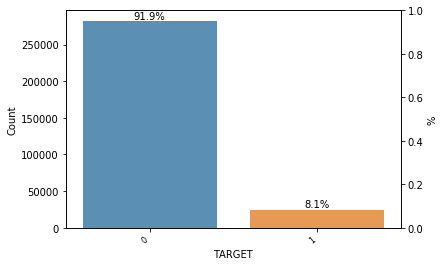

In [5]:
#sns.countplot(x='TARGET', data=df_application_train)
plot_counts(df_application_train, 'TARGET')
plt.show()

<a id="Insight_1"></a>**Insight: Majority of the clients do not have payment difficulties. This is an imbalanced dataset.**

In [6]:
# Drop any column that could pose potential discriminatory issues using in a model
# Gender, Family Status, Age, Area of Residence (Redlining), Type of Housing
cols2drop = ['CODE_GENDER', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 
             'DAYS_BIRTH', 'CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION', 
             'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
             'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
             'LIVE_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE', 
             'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY','APARTMENTS_AVG',
             'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
             'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
             'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
             'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
             'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE', 
             'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
             'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 
             'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
             'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
             'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
             'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
             'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 
             'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
             'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
             # Columns to drop based on intuition
             'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
             'FLAG_MOBIL', 'FLAG_EMP_PHONE' , 'FLAG_WORK_PHONE' ,'FLAG_CONT_MOBILE', 
             'FLAG_PHONE', 'FLAG_EMAIL', 'OWN_CAR_AGE',
             ]
df_application_train = df_application_train.drop(columns = cols2drop, axis = 1)

# Display top n records
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Identify where data are missing (nan values).

In [7]:
# Get columns nan counts
nan_counts = pd.DataFrame(df_application_train.isnull().sum())

nan_counts.reset_index(level=0, inplace=True)

# Select counts > 0
nan_counts[nan_counts[0] > 0]

,index,0
7,AMT_ANNUITY,12
8,AMT_GOODS_PRICE,278
15,OCCUPATION_TYPE,96391
17,EXT_SOURCE_1,173378
18,EXT_SOURCE_2,660
19,EXT_SOURCE_3,60965
20,OBS_30_CNT_SOCIAL_CIRCLE,1021
21,DEF_30_CNT_SOCIAL_CIRCLE,1021
22,OBS_60_CNT_SOCIAL_CIRCLE,1021
23,DEF_60_CNT_SOCIAL_CIRCLE,1021


Above features have 'nan' values. 56% records have N/A values for EXT_SOURCE_1. If we remove records with NaN values, we will only have 44% of the data left.

### 1.1.1. Any features that are not relevant to predict credit Risk?

Part of data cleansing for this dataset, we explore if there are any features that are not strong indicator to credit default risk. This is done by visualizing the feature values versus TARGET. Due to imbalanced dataset, stacked percentage bar charts are used to make the minority TARGET (i.e. 1 - credit default) values visible. Function 'plot_stacked_percentage_bar' in Library is used for this purpose.
**Any features that are not strong indicator to credit default will be removed from the dataset as part of data cleansing.**

#### Categorical features

In [8]:
# Review Categorical variables
df_application_train.describe(include='O')

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
count,307511,307511,307511,307511,307511,307511,211120,307511
unique,2,2,2,8,5,6,18,58
top,Cash loans,N,Y,Working,Secondary / secondary special,House / apartment,Laborers,Business Entity Type 3
freq,278232,202924,213312,158774,218391,272868,55186,67992


There are 8 categorical variables. We will look at distribution of TARGET based on categorial values. Features OCCUPATION_TYPE and ORGANIZATION_TYPE will be displayed on separate charts due to their high numbers of unique values.

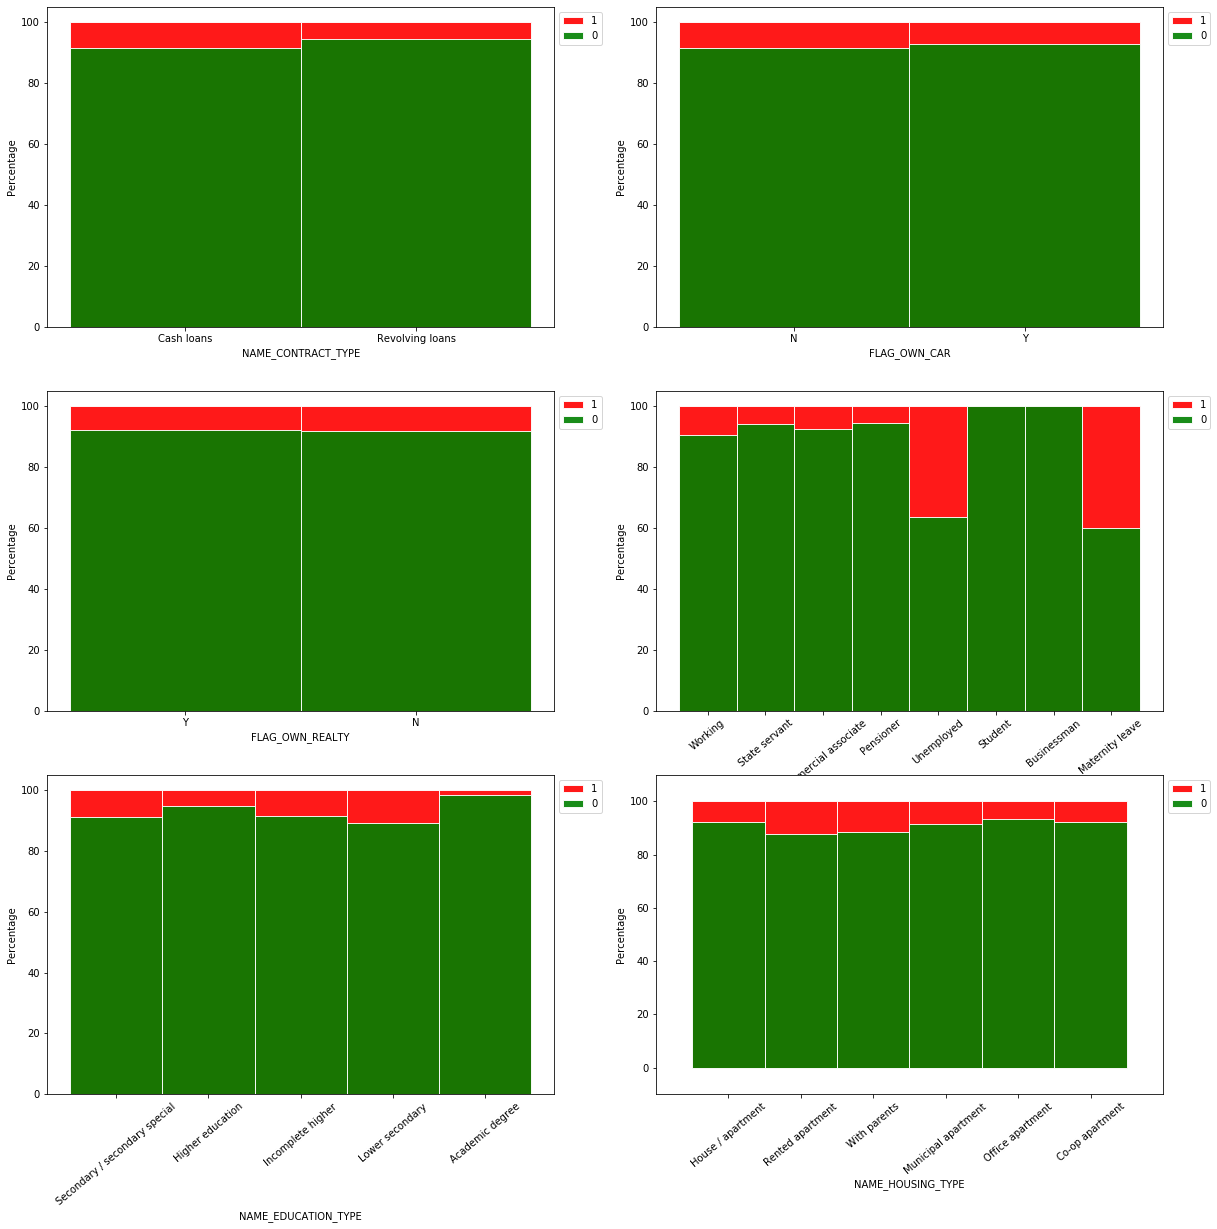

In [9]:
categorical_features = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']

fig, axis = plt.subplots(3,2,figsize = (20,20))
axis = axis.flatten()

pal = ['red', 'green']

for i, f in enumerate(categorical_features):
    df_percentage = category_percentage_by_target(df_application_train, 'TARGET', f)
    plot_stacked_percentage_bar(df_percentage, f, ax=axis[i], palette=pal)

<a id="Insight_2"></a>**Insights:**<br>
'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', and 'FLAG_OWN_REALTY' do not seem to be good predictors for default credit risk<br>
Meanwhile, 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE' and 'NAME_HOUSING_TYPE' seems to be better predictors of TARGET:<br>
NAME_INCOME_TYPE: Unemployed and Maternity Leave have higher risk of credit default<br/>
NAME_EDUCATION_TYPE: Higher education/Academic Degree have lower risk of credit default <br/>
NAME_HOUSING_TYPE:Rented Apartment and With parents have higher than average default rate

To simplify the features, we regroup these 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE' and 'NAME_HOUSING_TYPE' into high risk/low risk group and create dummies features for these group.

In [10]:
active_income_list = ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Student', 'Businessman']

df_application_train = replace_col_by_dummy (df_application_train, 'NAME_INCOME_TYPE',
                                        active_income_list, 'FLAG_ACTIVE_INCOME')

df_application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
#Create dummy for NAME_EDUCATION_NAME
higher_education_list = ['Higher education', 'Academic degree']

df_application_train = replace_col_by_dummy (df_application_train, 'NAME_EDUCATION_TYPE',
                                             higher_education_list, 'FLAG_HIGHER_EDUCATION')

df_application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [12]:
#Remove NAME_HOUSING_TYPE
higher_risk_housing_type = ['Rented apartment', 'With parents']

df_application_train = replace_col_by_dummy (df_application_train, 'NAME_HOUSING_TYPE',
                                             higher_risk_housing_type, 'FLAG_HIGHER_RISK_HOUSING_TYPE')

df_application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


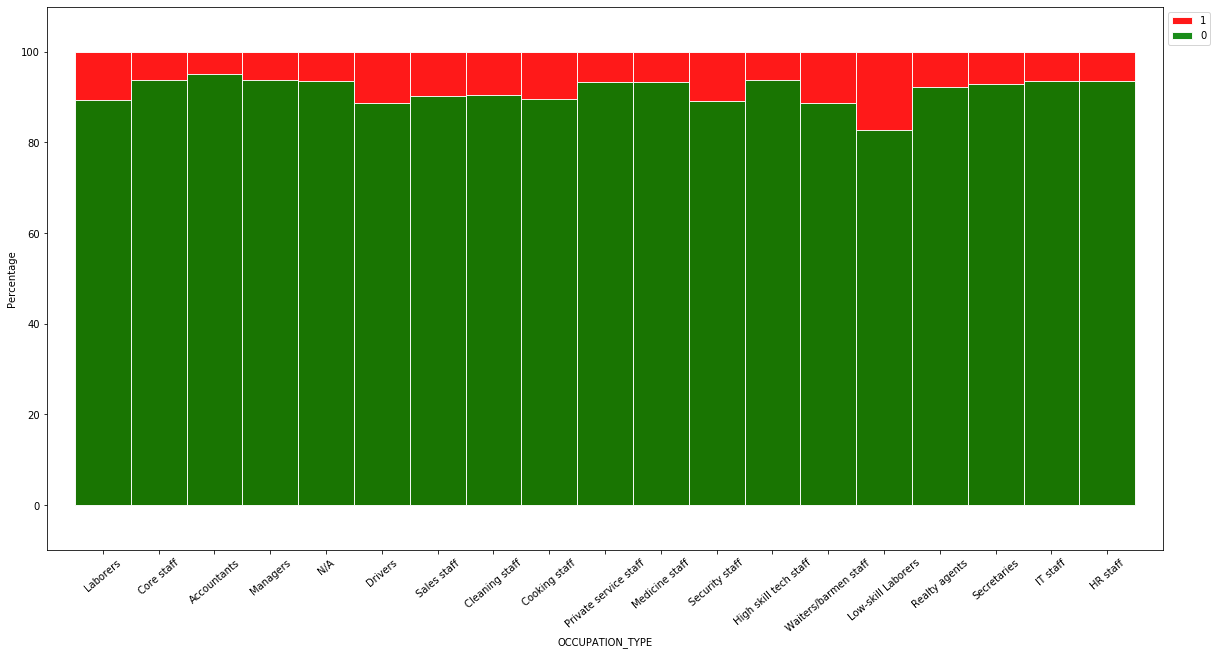

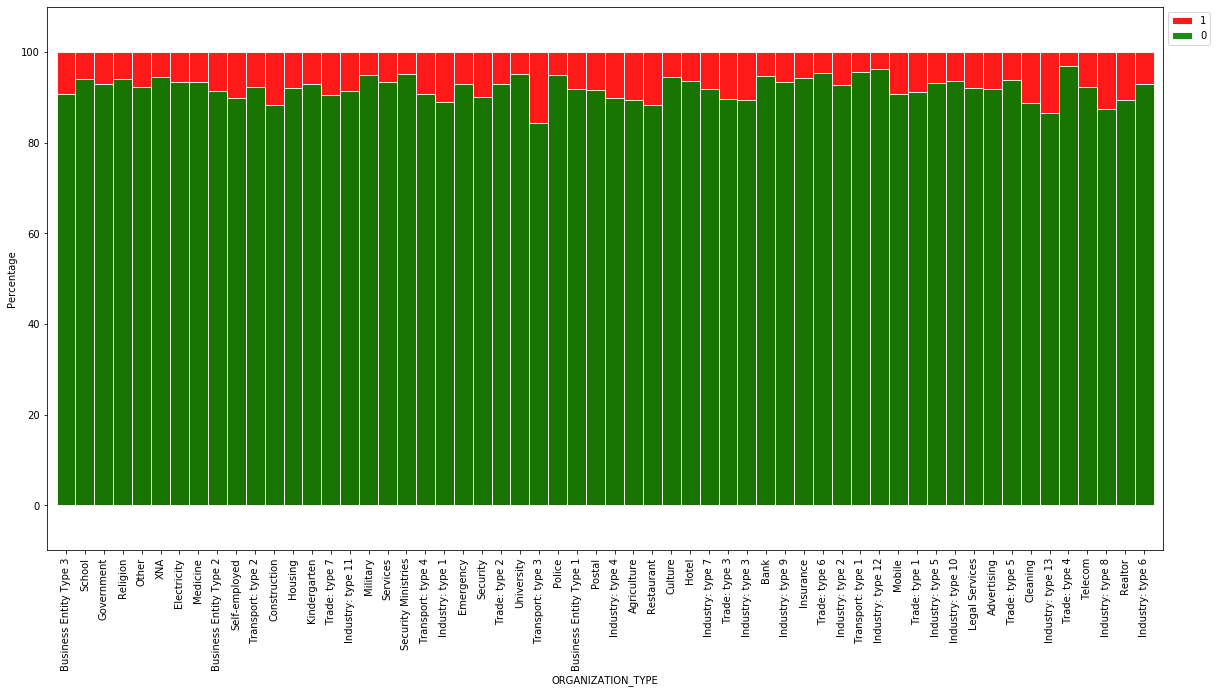

In [13]:
#Due to the number of unique values, OCCUPATION_TYPE and ORGANIZATION_TYPE need to be drawn on separate plots.
#Replace Occupation Type NULL value with 'N/A'
df_application_train['OCCUPATION_TYPE'] = df_application_train['OCCUPATION_TYPE'].fillna('N/A')
#draw OCCUPATION_TYPE
df_percentage = category_percentage_by_target(df_application_train, 'TARGET', 'OCCUPATION_TYPE')
plot_stacked_percentage_bar(df_percentage, 'OCCUPATION_TYPE', ax=None, palette=pal)

#draw ORGANIZATION_TYPE
df_percentage = category_percentage_by_target(df_application_train, 'TARGET', 'ORGANIZATION_TYPE')
plot_stacked_percentage_bar(df_percentage, 'ORGANIZATION_TYPE', ax=None, palette=pal)

categorical_features = categorical_features + ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

<a id="Insight_3"></a>**Insights:**<br>
OCCUPATION_TYPE and ORGANIZATION_TYPE seems to be strong predictors of TARGET:<br>

For these last 2 categorical variables, create HIGH_RISK, LOW_RISK flag based on the tolerance, which is set to 3%.

In [14]:
#TARGET distribution
num_of_entries = len(df_application_train)
per_default = (len(df_application_train[df_application_train['TARGET']==1])/num_of_entries)*100

#Set tolerance = 3% to split the data
TOLERANCE = 3

per_default

8.072881945686495

Any types of OCCUPATION_TYPE and ORGANIZATION_TYPE that have default risk below 5% will be classified in LOW_RISK and above 11% will be classified in HIGH_RISK

In [15]:
#OCCUPATION_TYPE
df_percentage = category_percentage_by_target(df_application_train, 'TARGET', 'OCCUPATION_TYPE')


#Create 2 OCCUPATION_TYPE dummy to replace OCCUPATION_TYPE
#FLAG_OCCUPATION_TYPE_LOW_RISK: has the default risk 3% (TOLERANCE) below average
#FLAG_OCCUPATION_TYPE_HIGH_RISK: has the default risk 3% (TOLERANCE) above average
occupation_type_low_risk_list = []
occupation_type_high_risk_list = []
for occupation_type in df_percentage.columns:
    if df_percentage[occupation_type].iloc[0] < (per_default - TOLERANCE):
        occupation_type_low_risk_list = occupation_type_low_risk_list + [occupation_type]
    if df_percentage[occupation_type].iloc[0] > (per_default + TOLERANCE):
        occupation_type_high_risk_list = occupation_type_high_risk_list + [occupation_type]

print('Low risk: ')
print(occupation_type_low_risk_list)
print('High risk: ')
print(occupation_type_high_risk_list)

Low risk: 
['Accountants']
High risk: 
['Drivers', 'Waiters/barmen staff', 'Low-skill Laborers']


In [16]:
df_application_train = replace_col_by_dummy (df_application_train, 'OCCUPATION_TYPE',
                                             occupation_type_high_risk_list, 'FLAG_OCCUPATION_HIGHER_RISK')
df_application_train = replace_col_by_dummy (df_application_train, 'OCCUPATION_TYPE',
                                             occupation_type_low_risk_list, 'FLAG_OCCUPATION_LOW_RISK')

df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE,FLAG_OCCUPATION_HIGHER_RISK,FLAG_OCCUPATION_LOW_RISK
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


In [17]:
#ORGANIZATION_TYPE
df_percentage = category_percentage_by_target(df_application_train, 'TARGET', 'ORGANIZATION_TYPE')


#Create 2 OCCUPATION_TYPE dummy to replace OCCUPATION_TYPE
#FLAG_ORGANIZATION_TYPE_LOW_RISK: has the default risk 3% (TOLERANCE) below average
#FLAG_ORGANIZATION_TYPE_HIGH_RISK: has the default risk 3% (TOLERANCE) above average
organization_type_low_risk_list = []
organization_type_high_risk_list = []
for organization_type in df_percentage.columns:
    if df_percentage[organization_type].iloc[0] < (per_default - TOLERANCE):
        organization_type_low_risk_list = organization_type_low_risk_list + [organization_type]
    if df_percentage[organization_type].iloc[0] > (per_default + TOLERANCE):
        organization_type_high_risk_list = organization_type_high_risk_list + [organization_type]

print('Low risk: ')
print(organization_type_low_risk_list)
print('High risk: ')
print(organization_type_high_risk_list)

Low risk: 
['Security Ministries', 'University', 'Police', 'Trade: type 6', 'Transport: type 1', 'Industry: type 12', 'Trade: type 4']
High risk: 
['Construction', 'Transport: type 3', 'Restaurant', 'Cleaning', 'Industry: type 13', 'Industry: type 8']


In [18]:
df_application_train = replace_col_by_dummy (df_application_train, 'ORGANIZATION_TYPE',
                                             organization_type_high_risk_list, 'FLAG_ORGANIZATION_HIGHER_RISK')
df_application_train = replace_col_by_dummy (df_application_train, 'ORGANIZATION_TYPE',
                                             organization_type_low_risk_list, 'FLAG_ORGANIZATION_LOW_RISK')

df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE,FLAG_OCCUPATION_HIGHER_RISK,FLAG_OCCUPATION_LOW_RISK,FLAG_ORGANIZATION_HIGHER_RISK,FLAG_ORGANIZATION_LOW_RISK
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0.0,0.0,1.0,1,0,0,0,0,0,0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0.0,0.0,0.0,1,1,0,0,0,0,0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,NaN,NaN,NaN,1,0,0,0,0,0,0
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0.0,0.0,0.0,1,0,0,0,0,0,0


To clean up, we drop all categorical features out of the dataset as they have been replaced by dummies columns mentioned above.

In [19]:
#All categorical features
df_application_train = df_application_train.drop(columns = categorical_features, axis = 1)
df_application_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE,FLAG_OCCUPATION_HIGHER_RISK,FLAG_OCCUPATION_LOW_RISK,FLAG_ORGANIZATION_HIGHER_RISK,FLAG_ORGANIZATION_LOW_RISK
0,100002,1,202500.0,406597.5,24700.5,351000.0,-637,-3648.0,-2120,0.083037,...,0.0,0.0,1.0,1,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-1186.0,-291,0.311267,...,0.0,0.0,0.0,1,1,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,-225,-4260.0,-2531,NaN,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,-3039,-9833.0,-2437,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,-3038,-4311.0,-3458,NaN,...,0.0,0.0,0.0,1,0,0,0,0,0,0


In [20]:
dummy_cols = ['FLAG_HIGHER_EDUCATION', 'FLAG_HIGHER_RISK_HOUSING_TYPE', 'FLAG_ACTIVE_INCOME',
              'FLAG_OCCUPATION_HIGHER_RISK', 'FLAG_OCCUPATION_LOW_RISK',
              'FLAG_ORGANIZATION_HIGHER_RISK',  'FLAG_ORGANIZATION_LOW_RISK']

#### Flag features

All 'FLAG_DOCUMENT' variables are treated as categorical (because they only have 2 values: 1 or 0). Filter them out and visualize as categorical variables. Flags considered a good predictor of TARGET have 5% difference between default risk percentage or not.

FLAG_DOCUMENT_2
FLAG_DOCUMENT_4
FLAG_DOCUMENT_10
FLAG_DOCUMENT_12
FLAG_DOCUMENT_13
FLAG_DOCUMENT_15
FLAG_DOCUMENT_17
FLAG_DOCUMENT_21


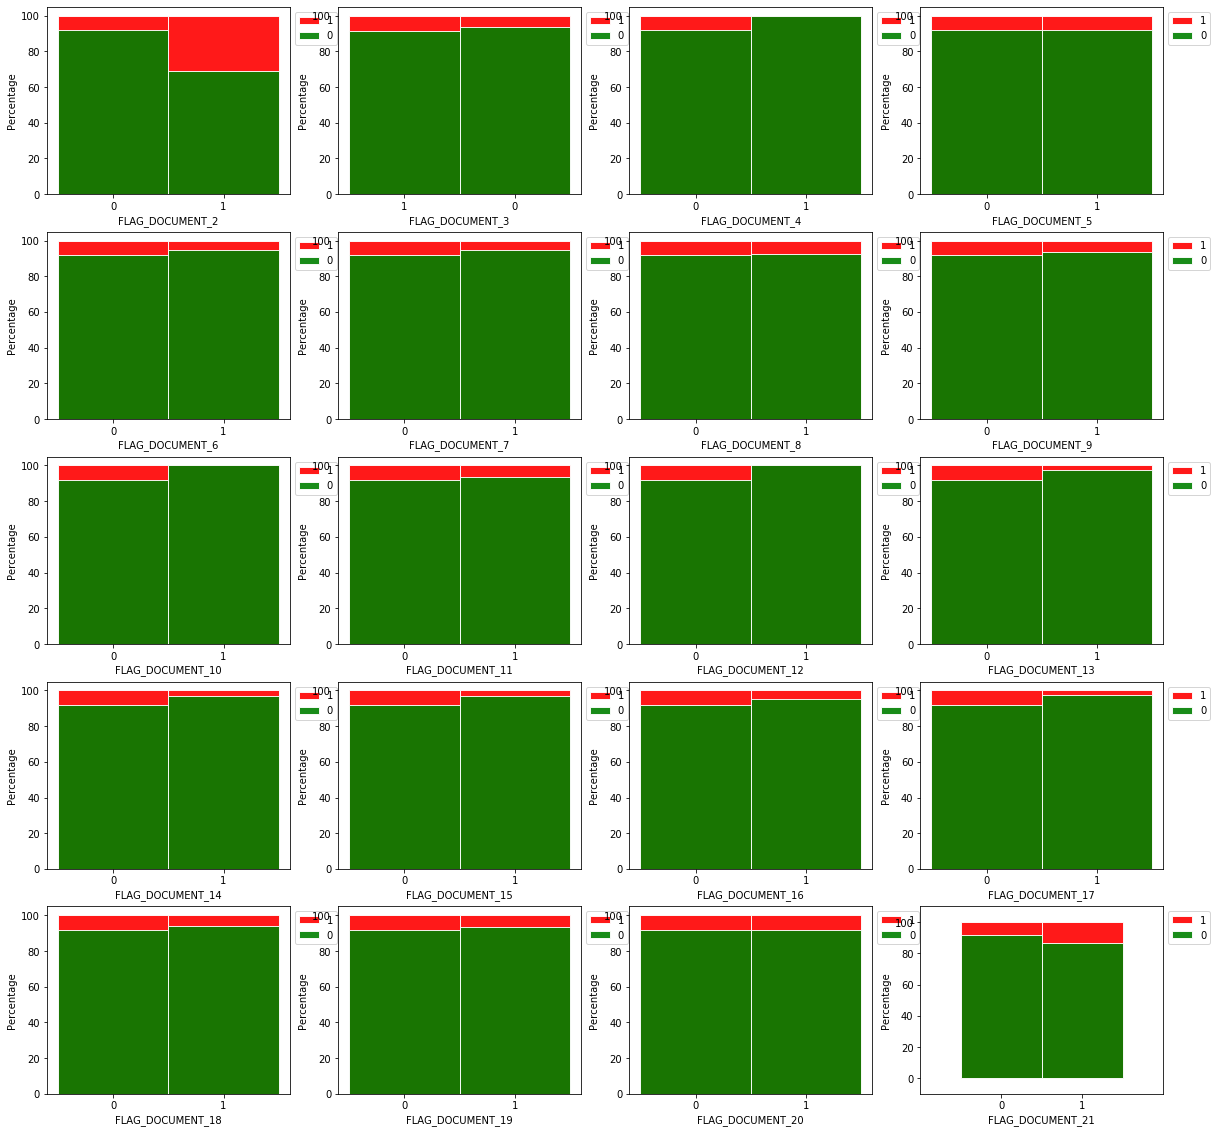

In [21]:
#Filter out 'FLAG_DOCUMENT' variables
flag_cols = [col for col in df_application_train if col.startswith('FLAG_DOCUMENT')]

fig, axis = plt.subplots(5,4,figsize = (20,20))
axis = axis.flatten()

pal = ['red', 'green']

for i, f in enumerate(flag_cols):
    df_percentage = category_percentage_by_target(df_application_train, 'TARGET', f)
    plot_stacked_percentage_bar(df_percentage, f, ax=axis[i], palette=pal)
    if abs(df_percentage[1].iloc[0] - df_percentage[0].iloc[0]) > 5:
        print(f)

<a id="Insight_4"></a>**Insights:**<br>
Based on above, velow flags suggest some contribution to default target<br>
<br>
FLAG_DOCUMENT_2<br>
FLAG_DOCUMENT_4<br>
FLAG_DOCUMENT_10<br>
FLAG_DOCUMENT_12<br>
FLAG_DOCUMENT_13<br>
FLAG_DOCUMENT_15<br>
FLAG_DOCUMENT_17<br>
FLAG_DOCUMENT_21

In [22]:
#Drop all the flags that are not good predictors
flags2keep = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_10',
              'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_15',
              'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_21']

flags2drop = list(set(flag_cols) - set(flags2keep))
flags2drop

['FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_9']

In [23]:
df_application_train = df_application_train.drop(columns = flags2drop, axis = 1)
df_application_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE,FLAG_OCCUPATION_HIGHER_RISK,FLAG_OCCUPATION_LOW_RISK,FLAG_ORGANIZATION_HIGHER_RISK,FLAG_ORGANIZATION_LOW_RISK
0,100002,1,202500.0,406597.5,24700.5,351000.0,-637,-3648.0,-2120,0.083037,...,0.0,0.0,1.0,1,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-1186.0,-291,0.311267,...,0.0,0.0,0.0,1,1,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,-225,-4260.0,-2531,NaN,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,-3039,-9833.0,-2437,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,-3038,-4311.0,-3458,NaN,...,0.0,0.0,0.0,1,0,0,0,0,0,0


#### Numerical features

Visualize the numerical variables using box plots. Decide what features to keep as good predictor. Clean outliers.

In [24]:
# Review Categorical variables
df_application_train.describe(include=np.number)

numerical_features = set(df_application_train.select_dtypes(include=np.number).columns)
numerical_features = list(numerical_features - set(['SK_ID_CURR', 'TARGET']+flags2keep+dummy_cols))
print('Number of numerical features: ' + '{}'.format(len(numerical_features)))
numerical_features

Number of numerical features: 21


['OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'EXT_SOURCE_1',
 'AMT_INCOME_TOTAL',
 'DAYS_ID_PUBLISH',
 'AMT_GOODS_PRICE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'DAYS_REGISTRATION',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'EXT_SOURCE_2',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_3']

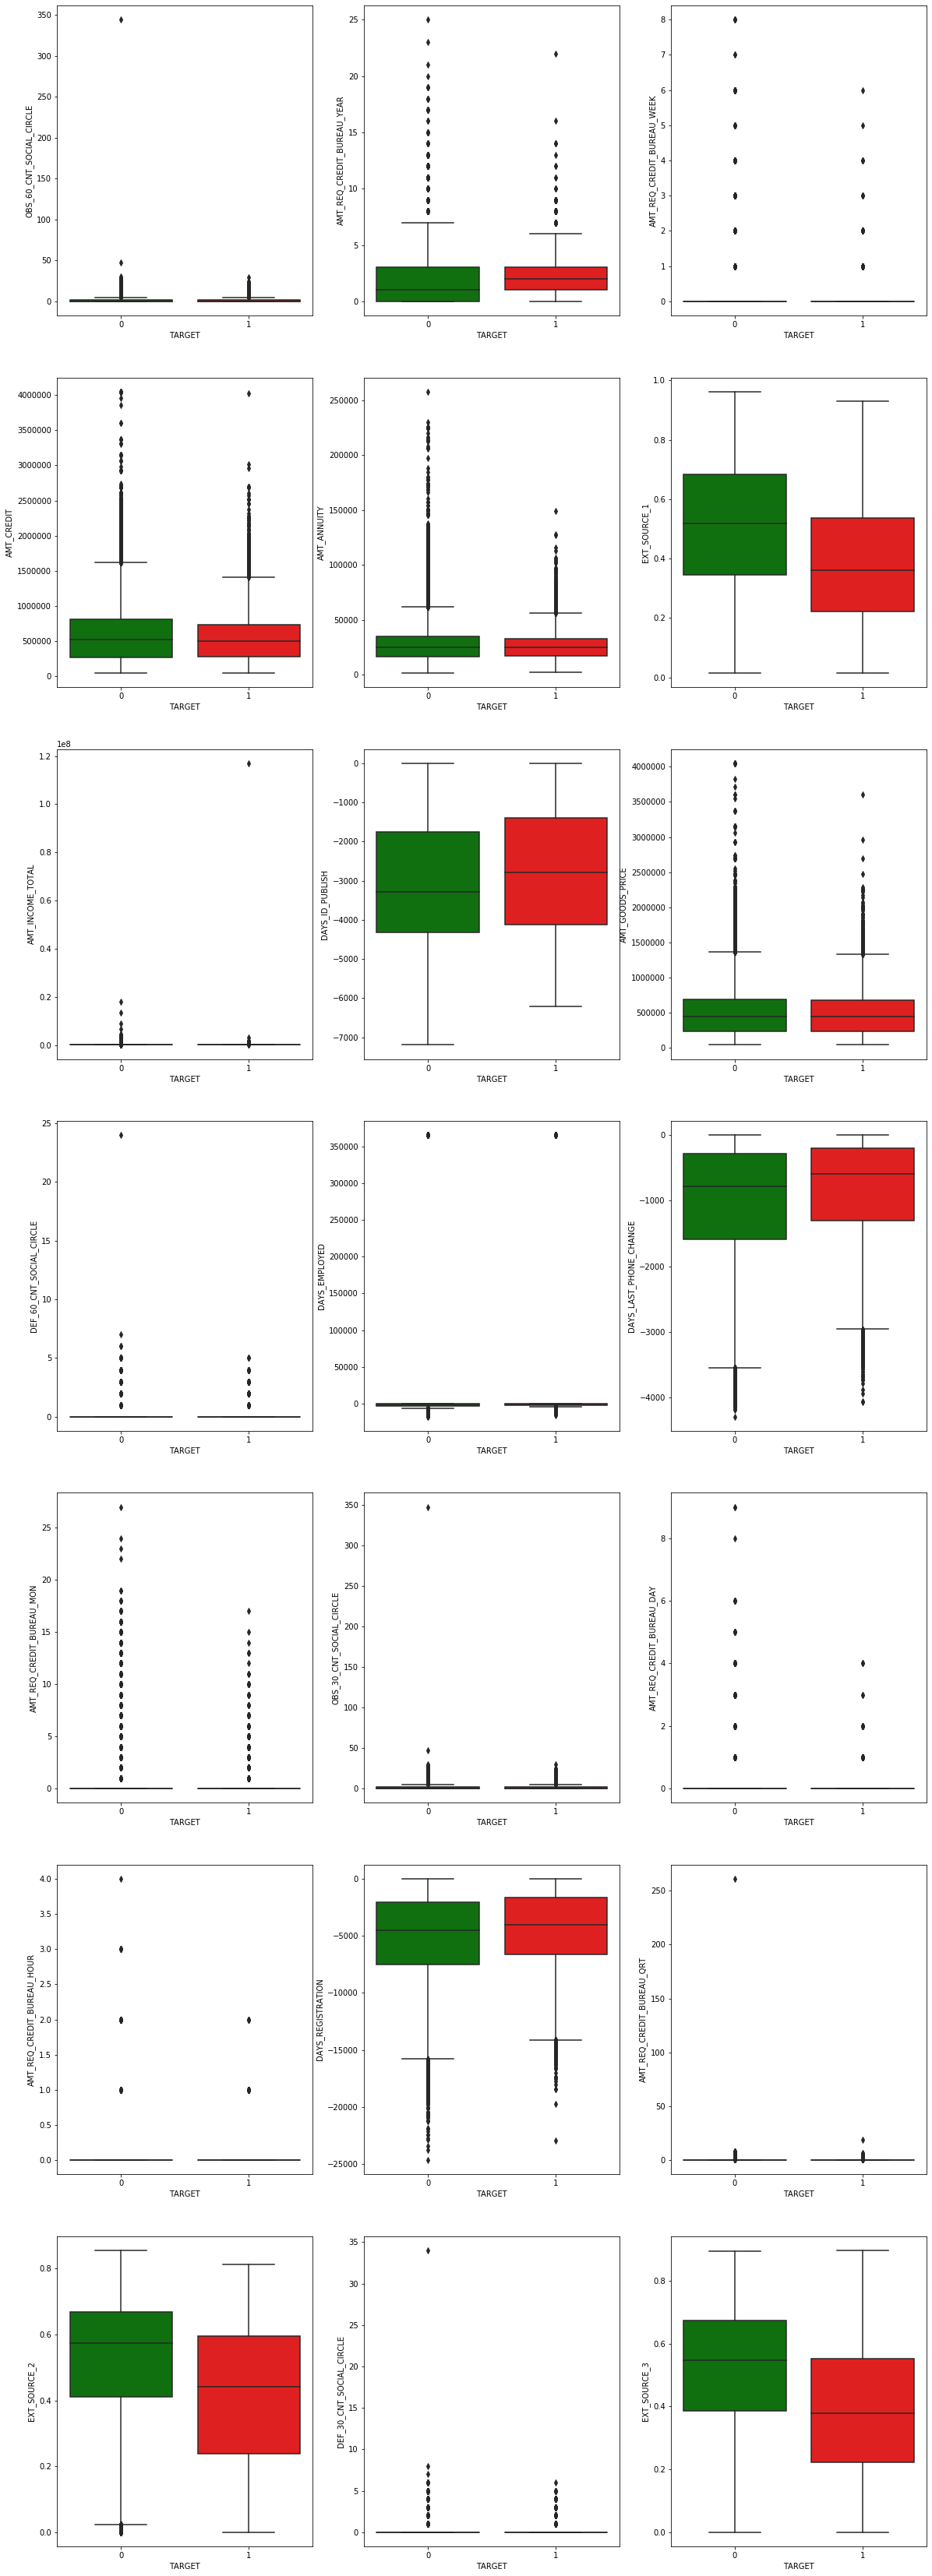

In [25]:
#Draw boxplots to examine the distribution of each numerical feature vs. TARGET
fig, axis = plt.subplots(7,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(numerical_features):
    sns.boxplot(y=f, x='TARGET', data=df_application_train, ax = axis[i], palette=pal)

**Data need cleaning for a closer look. Cleaning data below.**

In [26]:
display(remove_outlier(df_application_train[numerical_features]).head(5))

When we have not removed any outliers from the dataset, we have 307511 entries
When we have removed any outliers from the dataset, we have 121786 entries
The proportion of outliers which exist when compared to the dataframe are: 39.60%


,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_1,AMT_INCOME_TOTAL,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,DEF_60_CNT_SOCIAL_CIRCLE,...,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,OBS_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,DAYS_REGISTRATION,AMT_REQ_CREDIT_BUREAU_QRT,EXT_SOURCE_2,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3
1,1.0,0.0,0.0,1293502.5,35698.5,0.311267,270000.0,-291,1129500.0,0.0,...,-828.0,0.0,1.0,0.0,0.0,-1186.0,0.0,0.622246,0.0,NaN
2,0.0,0.0,0.0,135000.0,6750.0,NaN,67500.0,-2531,135000.0,0.0,...,-815.0,0.0,0.0,0.0,0.0,-4260.0,0.0,0.555912,0.0,0.729567
3,2.0,NaN,NaN,312682.5,29686.5,NaN,135000.0,-2437,297000.0,0.0,...,-617.0,NaN,2.0,NaN,NaN,-9833.0,NaN,0.650442,0.0,NaN
4,0.0,0.0,0.0,513000.0,21865.5,NaN,121500.0,-3458,513000.0,0.0,...,-1106.0,0.0,0.0,0.0,0.0,-4311.0,0.0,0.322738,0.0,NaN
9,2.0,NaN,NaN,405000.0,20250.0,NaN,135000.0,-3992,405000.0,0.0,...,-1673.0,NaN,2.0,NaN,NaN,-14437.0,NaN,0.746644,0.0,NaN


**Insights:**<br>**Removing outlier data entries will leave less than 40% of the dataset. Instead, replacing outliers with median to keep the data entries intact.**

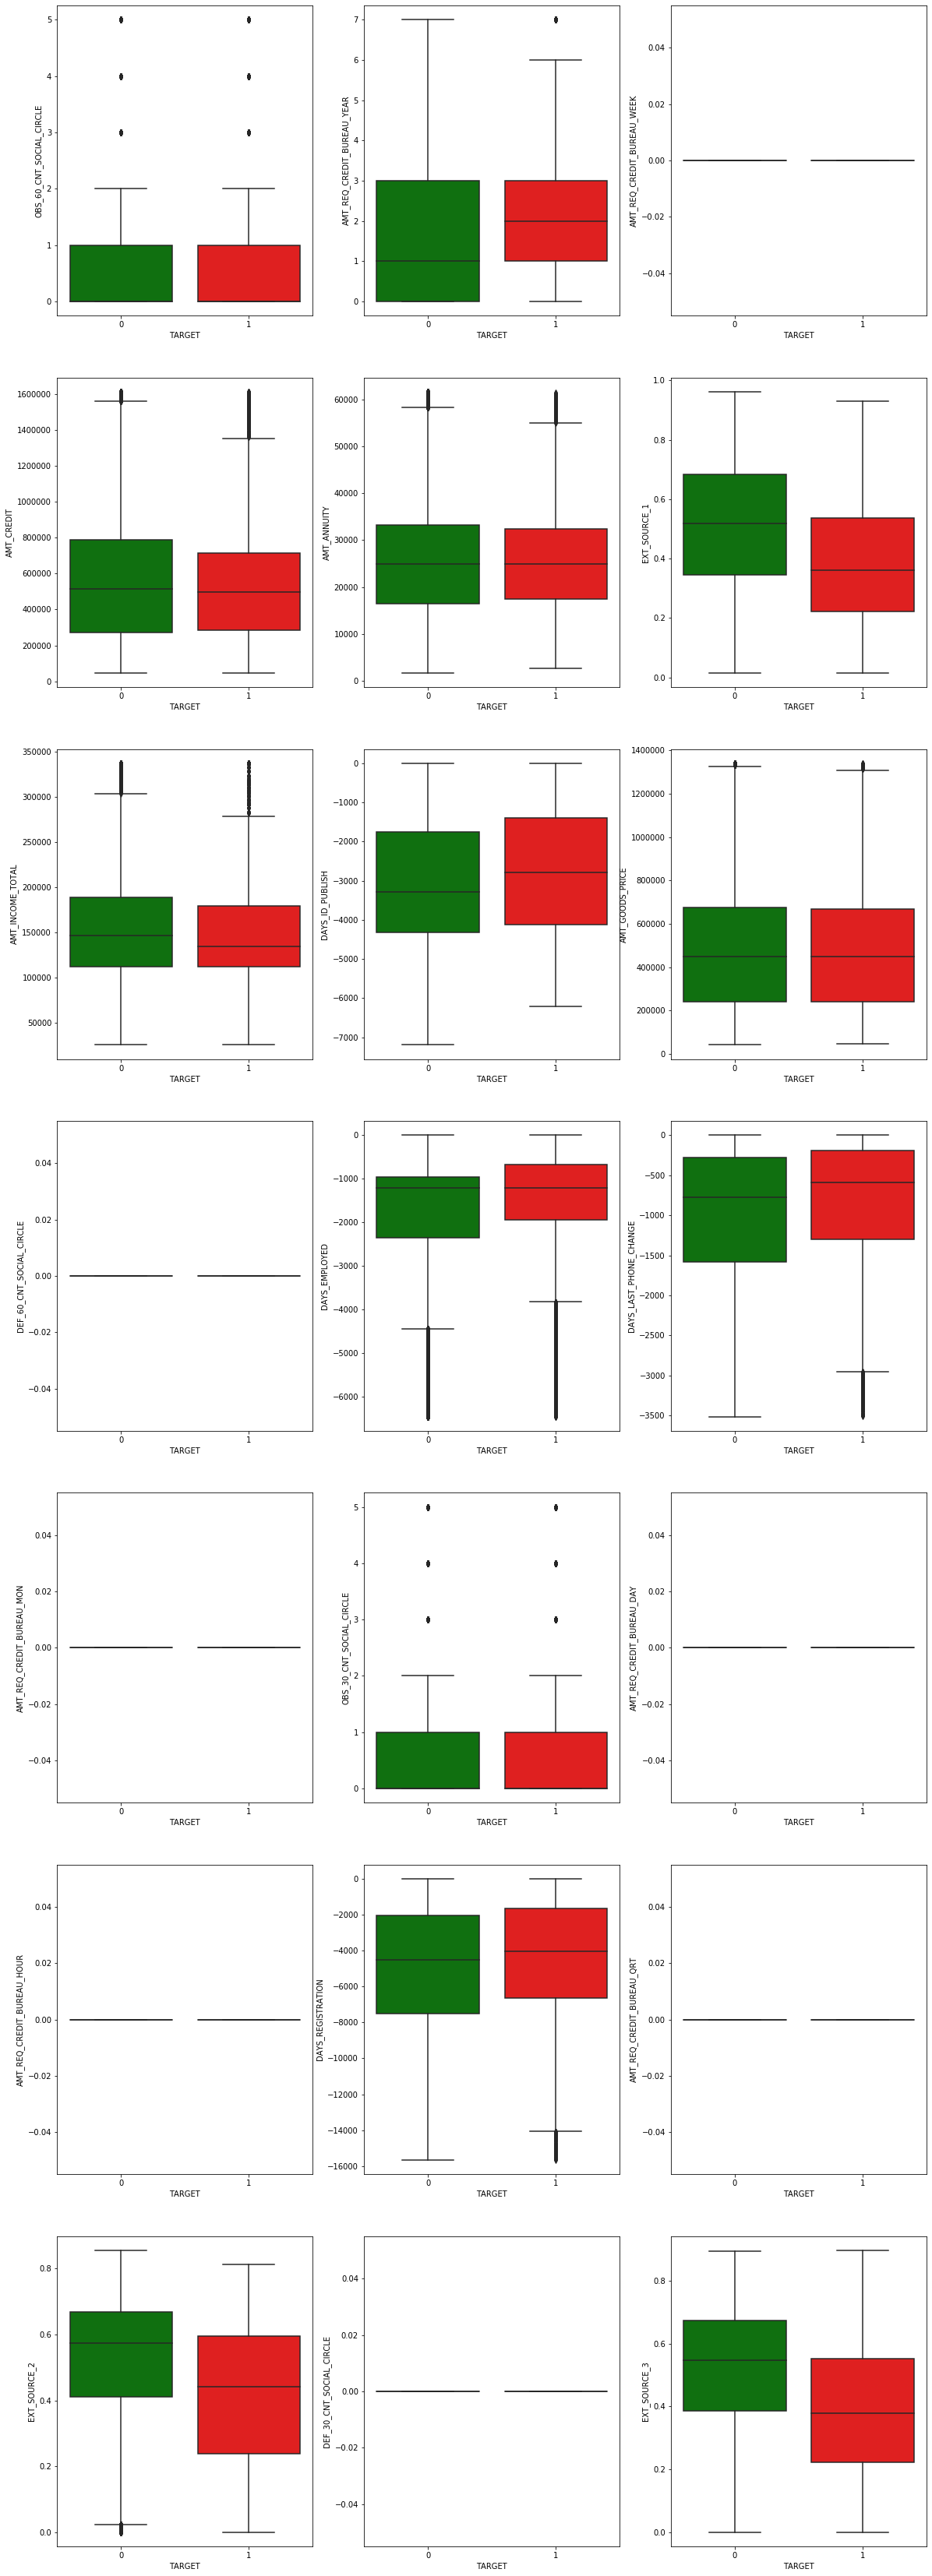

In [27]:
#Replace outliers with median value instead
replace_outlier(df_application_train, numerical_features)

#Draw boxplots to examine the distribution of each numerical feature vs. TARGET
fig, axis = plt.subplots(7,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(numerical_features):
    sns.boxplot(y=f, x='TARGET', data=df_application_train, ax = axis[i], palette=pal)

<a id="Insight_5"></a>**Insights:**<br>Some variables have unique values after removing outliers. These columns are not good predictor of TARGET and will be dropped from the data set:<br>

DEF_30_CNT_SOCIAL_CIRCLE<br>
AMT_REQ_CREDIT_BUREAU_QRT<br>
AMT_REQ_CREDIT_BUREAU_MON<br>
AMT_REQ_CREDIT_BUREAU_DAY<br>
AMT_REQ_CREDIT_BUREAU_HOUR<br>
DEF_60_CNT_SOCIAL_CIRCLE<br>
AMT_REQ_CREDIT_BUREAU_WEEK<br>

In [28]:
#Columns with unique values after removing outliers
cols2drop = ['DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_MON',
             'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'DEF_60_CNT_SOCIAL_CIRCLE',
             'AMT_REQ_CREDIT_BUREAU_WEEK']
df_application_train = df_application_train.drop(columns = cols2drop, axis = 1)
#Drop these columns from the numerical feature list
numerical_features = list(set(numerical_features) - set(cols2drop))

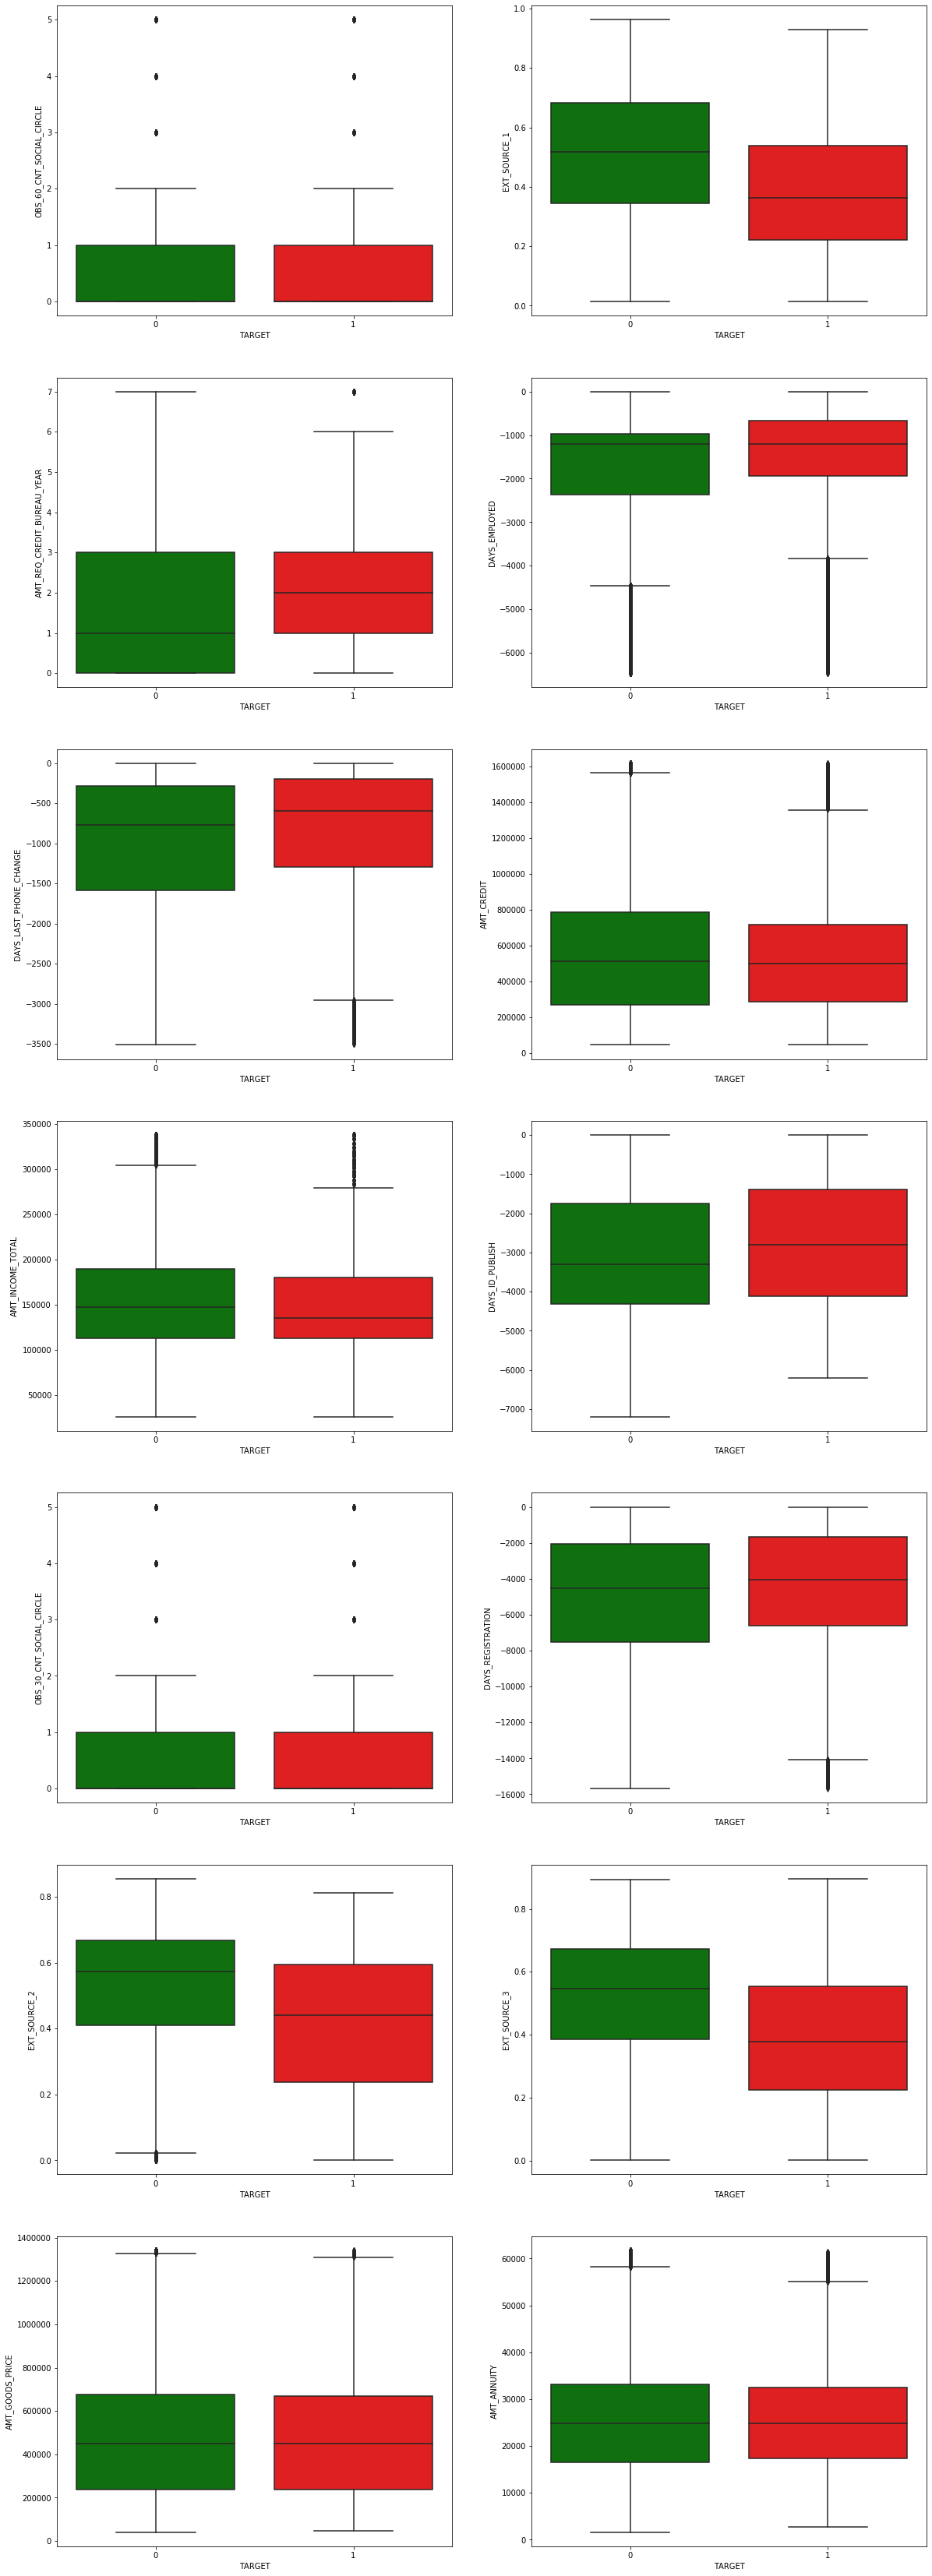

In [29]:
#Draw boxplots to examine the distribution of each numerical feature vs. TARGET
fig, axis = plt.subplots(7,2,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(numerical_features):
    sns.boxplot(y=f, x='TARGET', data=df_application_train, ax = axis[i], palette=pal)

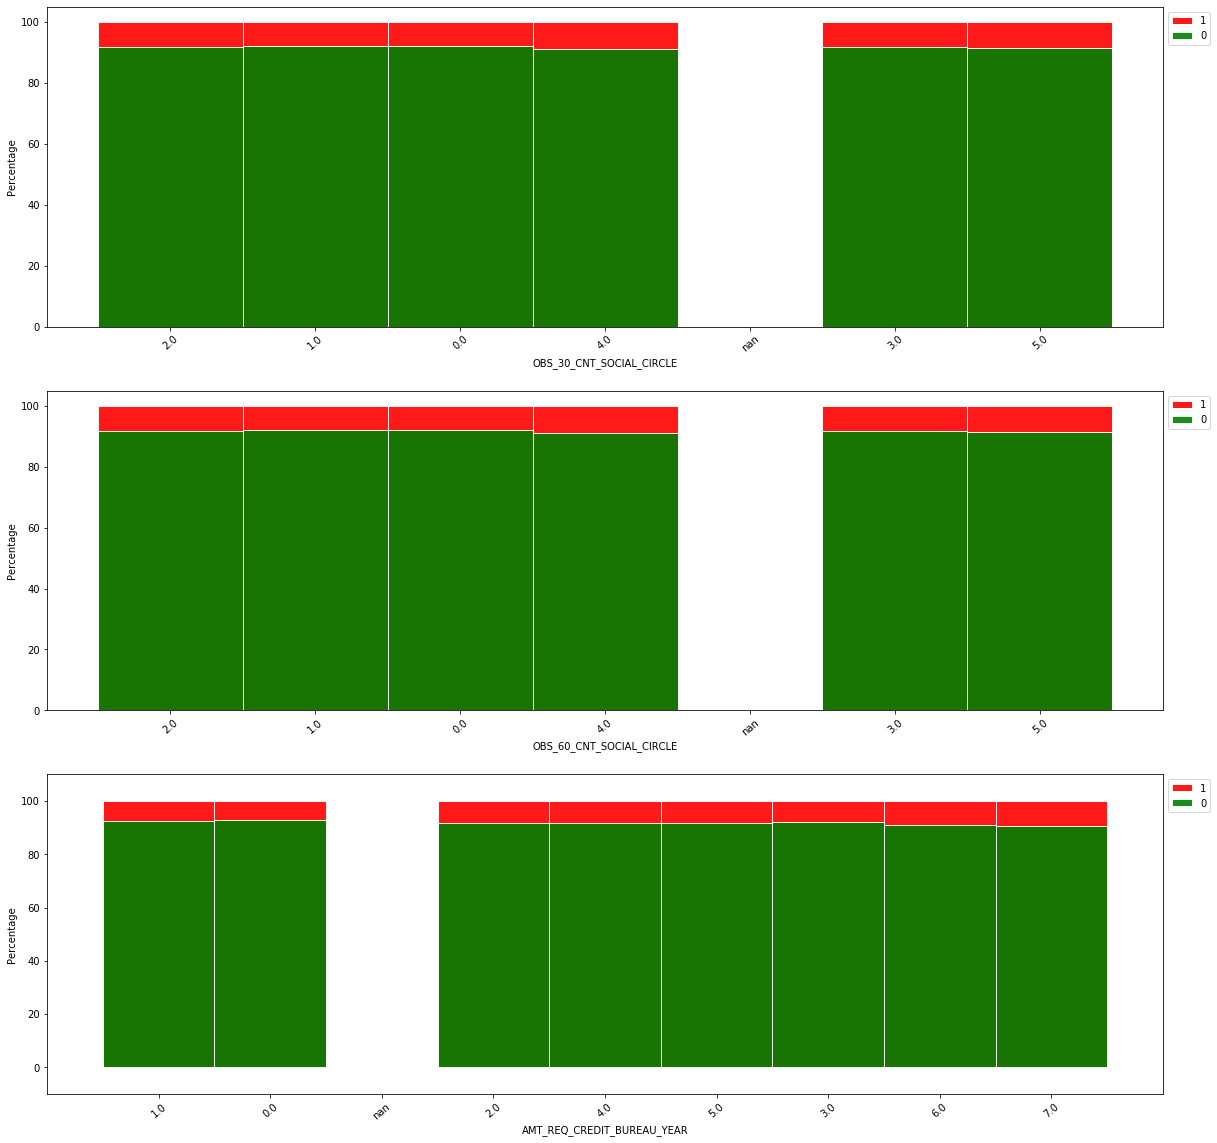

In [30]:
#Explore some numerical variables that have limited value and treat them as categorical
limited_value_numerical_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR']

fig, axis = plt.subplots(3,1,figsize = (20,20))
axis = axis.flatten()

pal = ['red', 'green']

for i, f in enumerate(limited_value_numerical_cols):
    df_percentage = category_percentage_by_target(df_application_train, 'TARGET', f)
    plot_stacked_percentage_bar(df_percentage, f, ax=axis[i], palette=pal)

Though the above charts suggest that mostly the some higher values have higher chance of default, the differences are not significant to consider in the model. Also, Data distribution of below variables does not change significantly by TARGET:

OBS_60_CNT_SOCIAL_CIRCLE<br>
OBS_30_CNT_SOCIAL_CIRCLE<br>
AMT_GOODS_PRICE<br>

In [31]:
cols2drop = ['OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE']
df_application_train = df_application_train.drop(columns = cols2drop, axis = 1)

**Identify where data are missing (nan values).**

In [32]:
# Get columns nan counts
nan_counts = pd.DataFrame(df_application_train.isnull().sum())

nan_counts.reset_index(level=0, inplace=True)

# Select counts > 0
nan_counts[nan_counts[0] > 0]

,index,0
4,AMT_ANNUITY,12
8,EXT_SOURCE_1,173378
9,EXT_SOURCE_2,660
10,EXT_SOURCE_3,60965
11,DAYS_LAST_PHONE_CHANGE,1
20,AMT_REQ_CREDIT_BUREAU_YEAR,41519


Above features have 'nan' values, which wil be replaced by median values. More sophisticated methods can be applied in the improvement stage, which is out of the context of this project.

In [33]:
nan_cols = ['AMT_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
           'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR']

#Replace nan with median values per feature
for f in nan_cols:
    df_application_train[f].fillna((df_application_train[f].median()), inplace=True)
    
# Get columns nan counts
nan_counts = pd.DataFrame(df_application_train.isnull().sum())

nan_counts.reset_index(level=0, inplace=True)

# Select counts > 0
nan_counts[nan_counts[0] > 0]

,index,0


In [34]:
display(df_application_train.head(5))
df_application_train.info()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_17,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_ACTIVE_INCOME,FLAG_HIGHER_EDUCATION,FLAG_HIGHER_RISK_HOUSING_TYPE,FLAG_OCCUPATION_HIGHER_RISK,FLAG_OCCUPATION_LOW_RISK,FLAG_ORGANIZATION_HIGHER_RISK,FLAG_ORGANIZATION_LOW_RISK
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,0,0,1.0,1,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,-1188,-1186.0,-291,0.311267,0.622246,...,0,0,0.0,1,1,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,-225,-4260.0,-2531,0.505998,0.555912,...,0,0,0.0,1,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,-3039,-9833.0,-2437,0.505998,0.650442,...,0,0,1.0,1,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,-3038,-4311.0,-3458,0.505998,0.322738,...,0,0,0.0,1,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 28 columns):
SK_ID_CURR                       307511 non-null int64
TARGET                           307511 non-null int64
AMT_INCOME_TOTAL                 307511 non-null float64
AMT_CREDIT                       307511 non-null float64
AMT_ANNUITY                      307511 non-null float64
DAYS_EMPLOYED                    307511 non-null int64
DAYS_REGISTRATION                307511 non-null float64
DAYS_ID_PUBLISH                  307511 non-null int64
EXT_SOURCE_1                     307511 non-null float64
EXT_SOURCE_2                     307511 non-null float64
EXT_SOURCE_3                     307511 non-null float64
DAYS_LAST_PHONE_CHANGE           307511 non-null float64
FLAG_DOCUMENT_2                  307511 non-null int64
FLAG_DOCUMENT_4                  307511 non-null int64
FLAG_DOCUMENT_10                 307511 non-null int64
FLAG_DOCUMENT_12                 307511 non-null

## 1.2. Bureau

In [35]:
#Load the BUREAU dataset
df_bureau = pd.read_csv(DATA_DIR + '/bureau.csv')

#Print BUREAU dataset info
display(df_bureau.head())
df_bureau.info()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


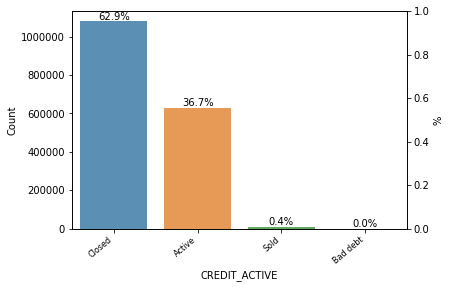

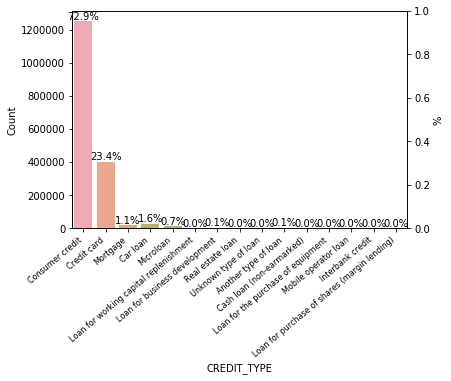

In [36]:
#bureau categorical features
bureau_categorical_features = ['CREDIT_ACTIVE', 'CREDIT_TYPE']

for f in bureau_categorical_features:
    plot_counts(df_bureau, f)

**Insights:**<br>Credit Close and Active are the majorities in Credit Active status. Consumer Credit and Credit Card are the majority in CREDIT TYPE<br>Create dummy values for these features, focusing on the major values:<br>
CREDIT_ACTIVE: count Closed, Active, Sold<br>
CREDIT_TYPE: Count CONSUMER_CREDIT, CREDIT_CARD, MORTGAGE, CAR_LOAN, MICROLOAN

In [37]:
#convert categorical features to dummy columns
dummy = pd.get_dummies(df_bureau[bureau_categorical_features])

#Standardize column names
rename_dict = dict()
for col in dummy.columns:
    rename_dict.update([(col, col.replace(' ','_').upper())])
dummy.rename(columns = rename_dict, inplace=True)

#Concat df_bureau and dummy
df_bureau = pd.concat([df_bureau, dummy], axis = 1)

display(df_bureau.head(1))

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,CREDIT_TYPE_INTERBANK_CREDIT,CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT,CREDIT_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_(MARGIN_LENDING),CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT,CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT,CREDIT_TYPE_MICROLOAN,CREDIT_TYPE_MOBILE_OPERATOR_LOAN,CREDIT_TYPE_MORTGAGE,CREDIT_TYPE_REAL_ESTATE_LOAN,CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#Column to count all bureau records
df_bureau['BUREAU_COUNT'] = 1

# Bureau records within 30 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= 0) & (df_bureau['DAYS_CREDIT'] >= -30), 'BUREAU_COUNT_30'] = 1
# Bureau records within 31-60 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -31) & (df_bureau['DAYS_CREDIT'] >= -60), 'BUREAU_COUNT_60'] = 1
# Bureau records within 61-120 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -61) & (df_bureau['DAYS_CREDIT'] >= -120), 'BUREAU_COUNT_120'] = 1
# Bureau records >= 121 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -121), 'BUREAU_COUNT_121_GT'] = 1

# Columns to sum
bureau_sum_cols = ['BUREAU_COUNT' , 'BUREAU_COUNT_30', 'BUREAU_COUNT_60', 
                   'BUREAU_COUNT_120', 'BUREAU_COUNT_121_GT',
                   #Dummy cols to use based on the plot count for CREDIT_TYPE
                   'CREDIT_TYPE_CONSUMER_CREDIT', 'CREDIT_TYPE_CREDIT_CARD', 'CREDIT_TYPE_MORTGAGE',
                   'CREDIT_TYPE_CAR_LOAN', 'CREDIT_TYPE_MICROLOAN',
                   #Dummy cols to use based on the plot count for CREDIT_ACTIVE
                   'CREDIT_ACTIVE_ACTIVE', 'CREDIT_ACTIVE_CLOSED', 'CREDIT_ACTIVE_SOLD']
                   

df_aggregated_bureau = pd.pivot_table(df_bureau, bureau_sum_cols, index = ['SK_ID_CURR'], aggfunc = np.sum)
display(df_aggregated_bureau.head(1))
df_aggregated_bureau.info()

,BUREAU_COUNT,BUREAU_COUNT_120,BUREAU_COUNT_121_GT,BUREAU_COUNT_30,BUREAU_COUNT_60,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_ACTIVE_SOLD,CREDIT_TYPE_CAR_LOAN,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,CREDIT_TYPE_MICROLOAN,CREDIT_TYPE_MORTGAGE
SK_ID_CURR,,,,,,,,,,,,,
100001,7,0.0,6.0,0.0,1.0,3,4,0,0,7,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 13 columns):
BUREAU_COUNT                   305811 non-null int64
BUREAU_COUNT_120               305811 non-null float64
BUREAU_COUNT_121_GT            305811 non-null float64
BUREAU_COUNT_30                305811 non-null float64
BUREAU_COUNT_60                305811 non-null float64
CREDIT_ACTIVE_ACTIVE           305811 non-null uint8
CREDIT_ACTIVE_CLOSED           305811 non-null uint8
CREDIT_ACTIVE_SOLD             305811 non-null uint8
CREDIT_TYPE_CAR_LOAN           305811 non-null uint8
CREDIT_TYPE_CONSUMER_CREDIT    305811 non-null uint8
CREDIT_TYPE_CREDIT_CARD        305811 non-null uint8
CREDIT_TYPE_MICROLOAN          305811 non-null uint8
CREDIT_TYPE_MORTGAGE           305811 non-null uint8
dtypes: float64(4), int64(1), uint8(8)
memory usage: 16.3 MB


In [39]:
#get ACTIVE bureau accounts only
df_active_bureau = df_bureau[df_bureau['CREDIT_ACTIVE']=='Active'].copy()

#Add  post fix '_ACTIVE' to differentiate with other variables in bureau
rename_dict = dict()
for col in df_active_bureau.columns:
    if col !=  'SK_ID_CURR':
        rename_dict.update([(col, col+'_ACTIVE')])
df_active_bureau.rename(columns = rename_dict, inplace=True)

# Columns to sum + key
# Based on a review of the count plot only include designated credit types
bureau_active_sum_cols = ['AMT_CREDIT_MAX_OVERDUE_ACTIVE', 'AMT_CREDIT_SUM_ACTIVE', 'AMT_CREDIT_SUM_DEBT_ACTIVE', 
                          'AMT_CREDIT_SUM_LIMIT_ACTIVE', 'AMT_CREDIT_SUM_OVERDUE_ACTIVE', 'AMT_ANNUITY_ACTIVE',
                          'CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE', 'CREDIT_TYPE_CREDIT_CARD_ACTIVE', 'CREDIT_TYPE_MORTGAGE_ACTIVE',
                          'CREDIT_TYPE_CAR_LOAN_ACTIVE', 'CREDIT_TYPE_MICROLOAN_ACTIVE']

df_aggregated_active_bureau = pd.pivot_table(df_active_bureau, bureau_active_sum_cols, index = ['SK_ID_CURR'], aggfunc = np.sum)
display(df_aggregated_active_bureau.head(1))
df_aggregated_active_bureau.info()

,AMT_ANNUITY_ACTIVE,AMT_CREDIT_MAX_OVERDUE_ACTIVE,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,AMT_CREDIT_SUM_LIMIT_ACTIVE,AMT_CREDIT_SUM_OVERDUE_ACTIVE,CREDIT_TYPE_CAR_LOAN_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE,CREDIT_TYPE_MICROLOAN_ACTIVE,CREDIT_TYPE_MORTGAGE_ACTIVE
SK_ID_CURR,,,,,,,,,,,
100001,24817.5,0.0,884025.0,596686.5,0.0,0.0,0,3,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 251815 entries, 100001 to 456255
Data columns (total 11 columns):
AMT_ANNUITY_ACTIVE                    251815 non-null float64
AMT_CREDIT_MAX_OVERDUE_ACTIVE         251815 non-null float64
AMT_CREDIT_SUM_ACTIVE                 251815 non-null float64
AMT_CREDIT_SUM_DEBT_ACTIVE            251815 non-null float64
AMT_CREDIT_SUM_LIMIT_ACTIVE           251815 non-null float64
AMT_CREDIT_SUM_OVERDUE_ACTIVE         251815 non-null float64
CREDIT_TYPE_CAR_LOAN_ACTIVE           251815 non-null uint8
CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE    251815 non-null uint8
CREDIT_TYPE_CREDIT_CARD_ACTIVE        251815 non-null uint8
CREDIT_TYPE_MICROLOAN_ACTIVE          251815 non-null uint8
CREDIT_TYPE_MORTGAGE_ACTIVE           251815 non-null uint8
dtypes: float64(6), uint8(5)
memory usage: 14.6 MB


In [40]:
df_bureau_final = pd.merge(df_aggregated_bureau, df_aggregated_active_bureau, on='SK_ID_CURR')
display(df_bureau_final.head(5))
#df_bureau_final.to_csv('bureau_final.csv')
df_bureau_final.info()

,BUREAU_COUNT,BUREAU_COUNT_120,BUREAU_COUNT_121_GT,BUREAU_COUNT_30,BUREAU_COUNT_60,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_ACTIVE_SOLD,CREDIT_TYPE_CAR_LOAN,CREDIT_TYPE_CONSUMER_CREDIT,...,AMT_CREDIT_MAX_OVERDUE_ACTIVE,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,AMT_CREDIT_SUM_LIMIT_ACTIVE,AMT_CREDIT_SUM_OVERDUE_ACTIVE,CREDIT_TYPE_CAR_LOAN_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE,CREDIT_TYPE_MICROLOAN_ACTIVE,CREDIT_TYPE_MORTGAGE_ACTIVE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,0.0,6.0,0.0,1.0,3,4,0,0,7,...,0.0,884025.000,596686.5,0.000,0.0,0,3,0,0,0
100002,8,1.0,7.0,0.0,0.0,2,6,0,0,4,...,40.5,481988.565,245781.0,31988.565,0.0,0,1,1,0,0
100003,4,0.0,4.0,0.0,0.0,1,3,0,0,2,...,0.0,810000.000,0.0,810000.000,0.0,0,0,1,0,0
100005,3,1.0,2.0,0.0,0.0,2,1,0,0,2,...,0.0,598626.000,568408.5,0.000,0.0,0,2,0,0,0
100008,3,1.0,2.0,0.0,0.0,1,2,0,0,3,...,0.0,267606.000,240057.0,0.000,0.0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 251815 entries, 100001 to 456255
Data columns (total 24 columns):
BUREAU_COUNT                          251815 non-null int64
BUREAU_COUNT_120                      251815 non-null float64
BUREAU_COUNT_121_GT                   251815 non-null float64
BUREAU_COUNT_30                       251815 non-null float64
BUREAU_COUNT_60                       251815 non-null float64
CREDIT_ACTIVE_ACTIVE                  251815 non-null uint8
CREDIT_ACTIVE_CLOSED                  251815 non-null uint8
CREDIT_ACTIVE_SOLD                    251815 non-null uint8
CREDIT_TYPE_CAR_LOAN                  251815 non-null uint8
CREDIT_TYPE_CONSUMER_CREDIT           251815 non-null uint8
CREDIT_TYPE_CREDIT_CARD               251815 non-null uint8
CREDIT_TYPE_MICROLOAN                 251815 non-null uint8
CREDIT_TYPE_MORTGAGE                  251815 non-null uint8
AMT_ANNUITY_ACTIVE                    251815 non-null float64
AMT_CREDIT_MAX_OVERDUE_ACTIVE     

## 1.3. Previous Application data

In [41]:
#Load the PREVIOUS APPLICATION dataset
df_prev_app = pd.read_csv(DATA_DIR + '/previous_application.csv')

#Print PREVIOUS APPLICATION dataset info
display(df_prev_app.head())
df_prev_app.info()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

In [42]:
# Flag if it was last application for the previous contract. 
# Sometimes by mistake of client or our clerk there could be more applications for one single contract

# Flag if the application was the last application per day of the client. 
# Sometimes clients apply for more applications a day. 
# Rarely it could also be error in our system that one application is in the database twice

# Get last previous applications filtered for last applications flags
df_prev_app_last = df_prev_app[(df_prev_app['FLAG_LAST_APPL_PER_CONTRACT'] == 'Y') & (df_prev_app['NFLAG_LAST_APPL_IN_DAY'] == 1)].copy()

print("Last previous application records: {}".format(len(df_prev_app_last)))

# Display top n records
display(df_prev_app_last.head(n=1))

Last previous application records: 1660953


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0


In [43]:
# Review Categorical variables to identify features that potentially will need dummy variables created
df_prev_app_last.describe(include=['O'])

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1660953,1660953,1660953,1660953,1660953,1660953,1660953,847781,1660953,1660953,1660953,1660953,1660953,1660953,1660953,1660607
unique,4,7,1,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747147,253697,1660953,913806,1036044,1032927,1352353,507349,1222935,941829,690743,1063381,715681,849324,508628,285990


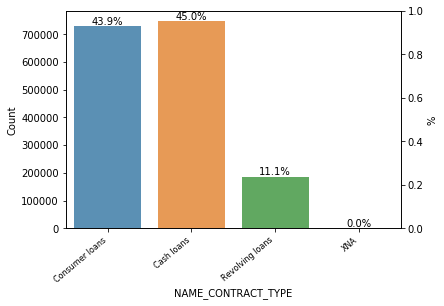

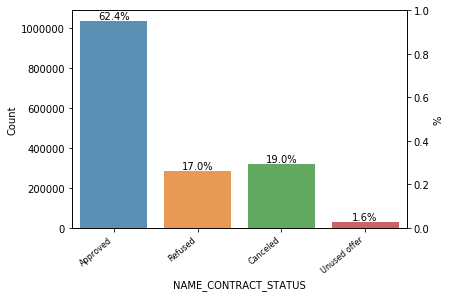

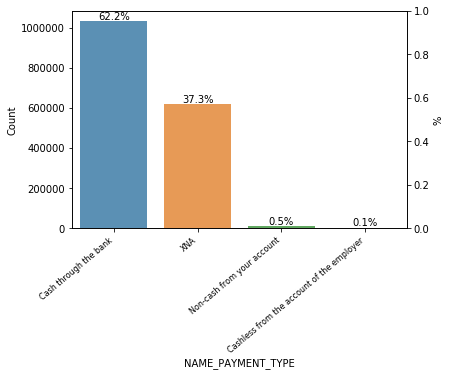

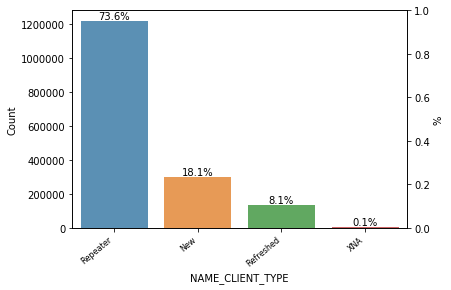

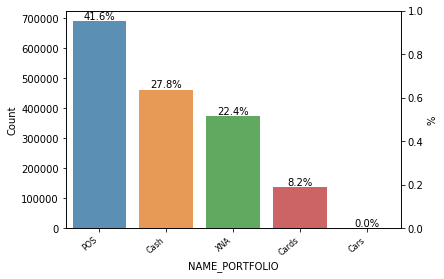

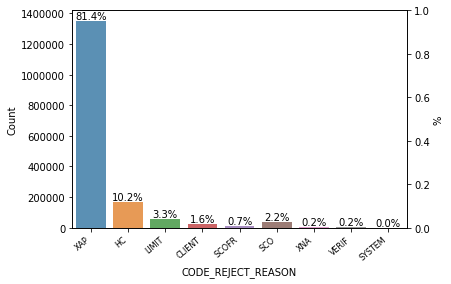

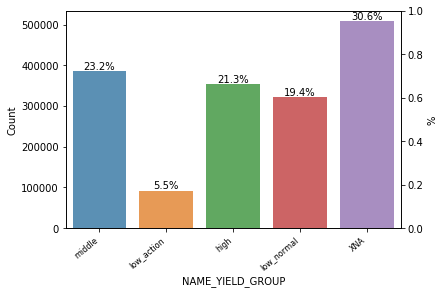

In [44]:
#All categorical features
previous_categorical_features  = ['NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE',
                                  'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON', 'NAME_YIELD_GROUP']

for f in previous_categorical_features:
    plot_counts(df_prev_app_last, f)

In [45]:
#Create dummy columns
dummy = pd.get_dummies(df_prev_app_last[previous_categorical_features])

#Standardize column names
rename_dict = dict()
for col in dummy.columns:
    rename_dict.update([(col, col.replace(' ','_').upper())])
dummy.rename(columns = rename_dict, inplace=True)

#Concat df_bureau and dummy
df_prev_app_last = pd.concat([df_prev_app_last, dummy], axis = 1)

# Difference between amount of credit granted vs. applied
df_prev_app_last['AMT_CREDIT_APPLCATION_DIFF'] = df_prev_app_last['AMT_CREDIT'] - df_prev_app_last['AMT_APPLICATION']

#Display top 5 records
display(df_prev_app_last.head(5))

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_HIGH,NAME_YIELD_GROUP_LOW_ACTION,NAME_YIELD_GROUP_LOW_NORMAL,NAME_YIELD_GROUP_MIDDLE,AMT_CREDIT_APPLCATION_DIFF
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0,0,1,0,0,0,0,0,1,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,0,0,1,0,0,0,1,0,0,72171.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0,0,1,0,0,1,0,0,0,23944.5
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,0,0,1,0,0,0,0,0,1,20790.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,0,0,0,0,0,1,0,0,0,66555.0


In [46]:
# Columns to sum + key
previous_application_last_sum_cols = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT',
                                      'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE'] + list(dummy)

print('List of columns to sum in Pivot Table: ' + str(len(previous_application_last_sum_cols)))
print(previous_application_last_sum_cols)

# Columns to average + key
previous_application_last_avg_cols = ['RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 
                                      'RATE_INTEREST_PRIVILEGED', 'CNT_PAYMENT', 'AMT_CREDIT_APPLCATION_DIFF']

print('List of columns to average in Pivot Table: '+ str(len(previous_application_last_avg_cols)))
print(previous_application_last_avg_cols)

List of columns to sum in Pivot Table: 40
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'NAME_CONTRACT_TYPE_CASH_LOANS', 'NAME_CONTRACT_TYPE_CONSUMER_LOANS', 'NAME_CONTRACT_TYPE_REVOLVING_LOANS', 'NAME_CONTRACT_TYPE_XNA', 'NAME_CONTRACT_STATUS_APPROVED', 'NAME_CONTRACT_STATUS_CANCELED', 'NAME_CONTRACT_STATUS_REFUSED', 'NAME_CONTRACT_STATUS_UNUSED_OFFER', 'NAME_PAYMENT_TYPE_CASH_THROUGH_THE_BANK', 'NAME_PAYMENT_TYPE_CASHLESS_FROM_THE_ACCOUNT_OF_THE_EMPLOYER', 'NAME_PAYMENT_TYPE_NON-CASH_FROM_YOUR_ACCOUNT', 'NAME_PAYMENT_TYPE_XNA', 'NAME_CLIENT_TYPE_NEW', 'NAME_CLIENT_TYPE_REFRESHED', 'NAME_CLIENT_TYPE_REPEATER', 'NAME_CLIENT_TYPE_XNA', 'NAME_PORTFOLIO_CARDS', 'NAME_PORTFOLIO_CARS', 'NAME_PORTFOLIO_CASH', 'NAME_PORTFOLIO_POS', 'NAME_PORTFOLIO_XNA', 'CODE_REJECT_REASON_CLIENT', 'CODE_REJECT_REASON_HC', 'CODE_REJECT_REASON_LIMIT', 'CODE_REJECT_REASON_SCO', 'CODE_REJECT_REASON_SCOFR', 'CODE_REJECT_REASON_SYSTEM', 'CODE_REJECT_REASON_VERIF', 'CODE_RE

In [47]:
aggregated_prev_app_last_sum = pd.pivot_table(df_prev_app_last,
                                              values=previous_application_last_sum_cols,
                                              index='SK_ID_CURR',
                                              aggfunc = np.sum)


aggregated_prev_app_last_avg = pd.pivot_table(df_prev_app_last,
                                              values=previous_application_last_avg_cols,
                                              index='SK_ID_CURR',
                                              aggfunc = np.nanmean, fill_value=0)
#Merge these 2 pivot tables into final previous application database
df_final_prev_application = pd.merge(aggregated_prev_app_last_sum, aggregated_prev_app_last_avg, on='SK_ID_CURR')

#Add "PREV" prefix to all column names to avoid duplicate when merging with other database
#Add  post fix '_ACTIVE' to differentiate with other variables in bureau
rename_dict = dict()
for col in df_final_prev_application.columns:
    rename_dict.update([(col, col+'_PREV')])
df_final_prev_application.rename(columns = rename_dict, inplace=True)

display(df_final_prev_application.head(5))
df_final_prev_application.info()

,AMT_ANNUITY_PREV,AMT_APPLICATION_PREV,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,CODE_REJECT_REASON_CLIENT_PREV,CODE_REJECT_REASON_HC_PREV,CODE_REJECT_REASON_LIMIT_PREV,CODE_REJECT_REASON_SCO_PREV,CODE_REJECT_REASON_SCOFR_PREV,...,NAME_YIELD_GROUP_HIGH_PREV,NAME_YIELD_GROUP_LOW_ACTION_PREV,NAME_YIELD_GROUP_LOW_NORMAL_PREV,NAME_YIELD_GROUP_MIDDLE_PREV,NAME_YIELD_GROUP_XNA_PREV,AMT_CREDIT_APPLCATION_DIFF_PREV,CNT_PAYMENT_PREV,RATE_DOWN_PAYMENT_PREV,RATE_INTEREST_PRIMARY_PREV,RATE_INTEREST_PRIVILEGED_PREV
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,24835.5,23787.0,2520.0,24835.5,0,0,0,0,0,...,1,0,0,0,0,-1048.5,8.0,0.104326,0.0,0.0
100002,9251.775,179055.0,179055.0,0.0,179055.0,0,0,0,0,0,...,0,0,1,0,0,0.0,24.0,0.000000,0.0,0.0
100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,0,0,0,0,0,...,0,0,1,2,0,48754.5,10.0,0.050030,0.0,0.0
100004,5357.250,24282.0,20106.0,4860.0,24282.0,0,0,0,0,0,...,0,0,0,1,0,-4176.0,4.0,0.212008,0.0,0.0
100005,4813.200,44617.5,40153.5,4464.0,44617.5,0,0,0,0,0,...,1,0,0,0,1,-2232.0,12.0,0.108964,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 338810 entries, 100001 to 456255
Data columns (total 45 columns):
AMT_ANNUITY_PREV                                                    338810 non-null float64
AMT_APPLICATION_PREV                                                338810 non-null float64
AMT_CREDIT_PREV                                                     338810 non-null float64
AMT_DOWN_PAYMENT_PREV                                               338810 non-null float64
AMT_GOODS_PRICE_PREV                                                338810 non-null float64
CODE_REJECT_REASON_CLIENT_PREV                                      338810 non-null uint8
CODE_REJECT_REASON_HC_PREV                                          338810 non-null uint8
CODE_REJECT_REASON_LIMIT_PREV                                       338810 non-null uint8
CODE_REJECT_REASON_SCO_PREV                                         338810 non-null uint8
CODE_REJECT_REASON_SCOFR_PREV                                   

In [48]:
#df_final_prev_application.to_csv('final previous application.csv')

## 1.4. Combine Bureau and Previous Application data to the main Application Train data

In [49]:
#Merge Bureau and Previous Application with Application Database
df_merged_app = pd.merge(df_application_train, df_final_prev_application, how='left', on='SK_ID_CURR')
df_merged_app = pd.merge(df_merged_app, df_bureau_final, how='left', on='SK_ID_CURR')
df_merged_app.head(5)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,AMT_CREDIT_MAX_OVERDUE_ACTIVE,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,AMT_CREDIT_SUM_LIMIT_ACTIVE,AMT_CREDIT_SUM_OVERDUE_ACTIVE,CREDIT_TYPE_CAR_LOAN_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE,CREDIT_TYPE_MICROLOAN_ACTIVE,CREDIT_TYPE_MORTGAGE_ACTIVE
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,40.5,481988.565,245781.0,31988.565,0.0,0.0,1.0,1.0,0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,-1188,-1186.0,-291,0.311267,0.622246,...,0.0,810000.000,0.0,810000.000,0.0,0.0,0.0,1.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,-225,-4260.0,-2531,0.505998,0.555912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,135000.0,312682.5,29686.5,-3039,-9833.0,-2437,0.505998,0.650442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,121500.0,513000.0,21865.5,-3038,-4311.0,-3458,0.505998,0.322738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#If an entry does not have any data in previous application/Bureau, all the columns from those tables should be filled by 0
new_cols = list(df_final_prev_application.columns) + list(df_bureau_final)
df_merged_app[new_cols] = df_merged_app[new_cols].fillna(0)
df_merged_app.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,AMT_CREDIT_MAX_OVERDUE_ACTIVE,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,AMT_CREDIT_SUM_LIMIT_ACTIVE,AMT_CREDIT_SUM_OVERDUE_ACTIVE,CREDIT_TYPE_CAR_LOAN_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE,CREDIT_TYPE_MICROLOAN_ACTIVE,CREDIT_TYPE_MORTGAGE_ACTIVE
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,40.5,481988.565,245781.0,31988.565,0.0,0.0,1.0,1.0,0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,-1188,-1186.0,-291,0.311267,0.622246,...,0.0,810000.000,0.0,810000.000,0.0,0.0,0.0,1.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,-225,-4260.0,-2531,0.505998,0.555912,...,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,-3039,-9833.0,-2437,0.505998,0.650442,...,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,121500.0,513000.0,21865.5,-3038,-4311.0,-3458,0.505998,0.322738,...,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Insights

## 2.1. Application Train data insights

**Insights: Majority of the clients do not have payment difficulties. This is an imbalanced dataset.** [See chart](#Insight_1)

**[Insights: ](#Insight_2)**<br>
'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', and 'FLAG_OWN_REALTY' do not seem to be good predictors for default credit risk<br>
Meanwhile, 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE' and 'NAME_HOUSING_TYPE' seems to be better predictors of TARGET:<br>
NAME_INCOME_TYPE: Unemployed and Maternity Leave (without active income) have higher risk of credit default<br/>
NAME_EDUCATION_TYPE: Higher education/Academic Degree have lower risk of credit default <br/>
NAME_HOUSING_TYPE:Rented Apartment and With parents have higher than average default rate

**[Insights:](#Insight_3)**<br>
OCCUPATION_TYPE and ORGANIZATION_TYPE seems to be strong predictors of TARGET.<br>

**Insights:**<br>
Based on [above](#Insight_4), below flags suggest some contribution to default target<br>
<br>
FLAG_DOCUMENT_2: Applicants who can provide document 2 have higher chance of default<br>
FLAG_DOCUMENT_4<br>
FLAG_DOCUMENT_10<br>
FLAG_DOCUMENT_12<br>
FLAG_DOCUMENT_13<br>
FLAG_DOCUMENT_15<br>
FLAG_DOCUMENT_17<br>
FLAG_DOCUMENT_21<br>

**Insights:**<br>Some variables have unique values after removing outliers ([see charts](#Insight_4)). These columns are not good predictor of TARGET and will be dropped from the data set:<br>

DEF_30_CNT_SOCIAL_CIRCLE<br>
AMT_REQ_CREDIT_BUREAU_QRT<br>
AMT_REQ_CREDIT_BUREAU_MON<br>
AMT_REQ_CREDIT_BUREAU_DAY<br>
AMT_REQ_CREDIT_BUREAU_HOUR<br>
DEF_60_CNT_SOCIAL_CIRCLE<br>
AMT_REQ_CREDIT_BUREAU_WEEK<br>

## 2.2. Bureau data

### Any features in Bureau data correlates with TARGET?

We try to answer above question using box plots to see if the distribution of the features change between 2 TARGET values.

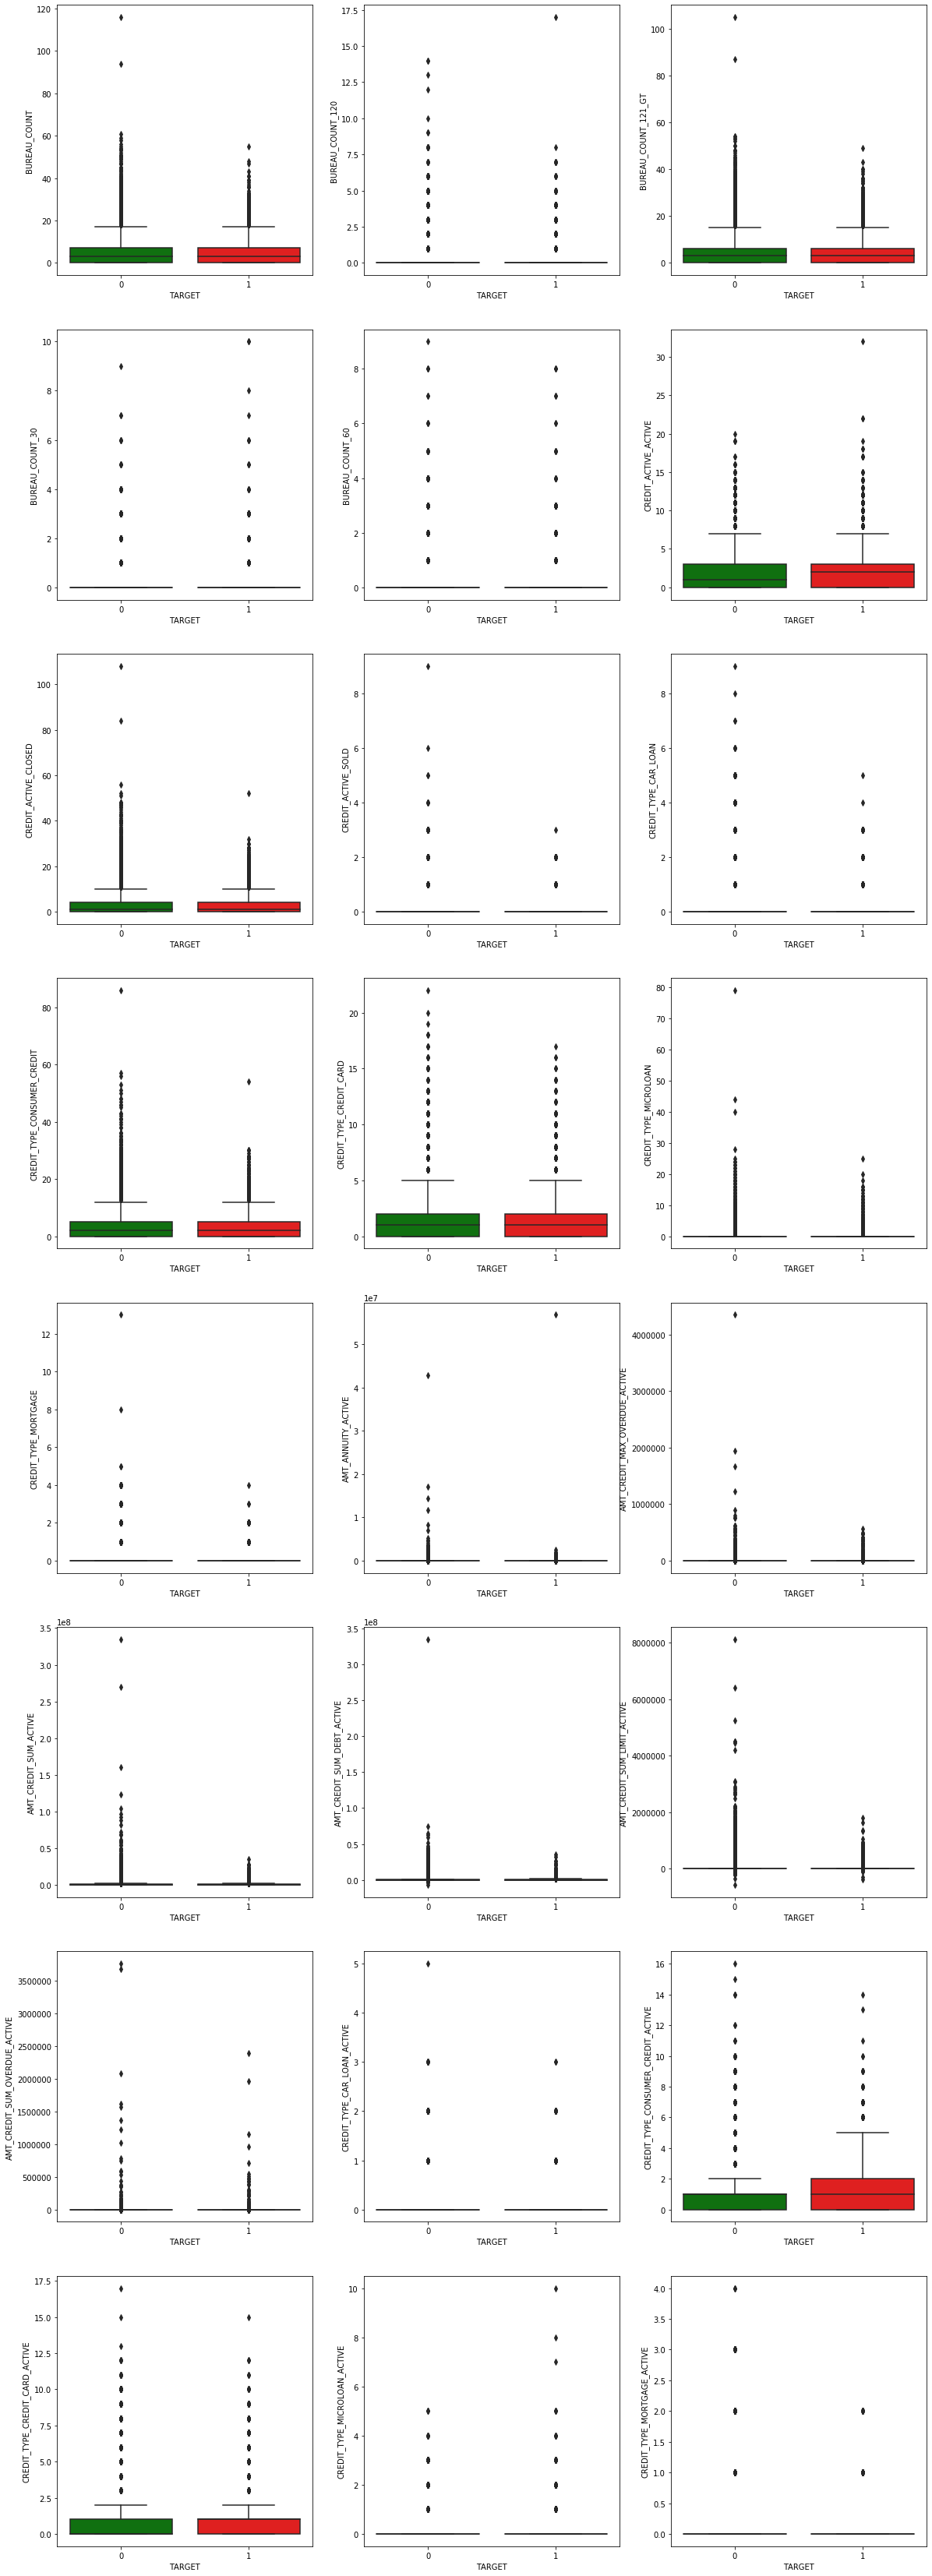

In [51]:
bureau_cols = list(df_bureau_final.columns)

#Plot box plots between bureau columns vs. TARGET
fig, axis = plt.subplots(8,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(bureau_cols):
    sns.boxplot(y=f, x='TARGET', data=df_merged_app, ax = axis[i], palette=pal)

**Insight:** There are a lot of outliers which affect the distribution. The outliers will be replaced by medians, so we can have better view of data distributions.

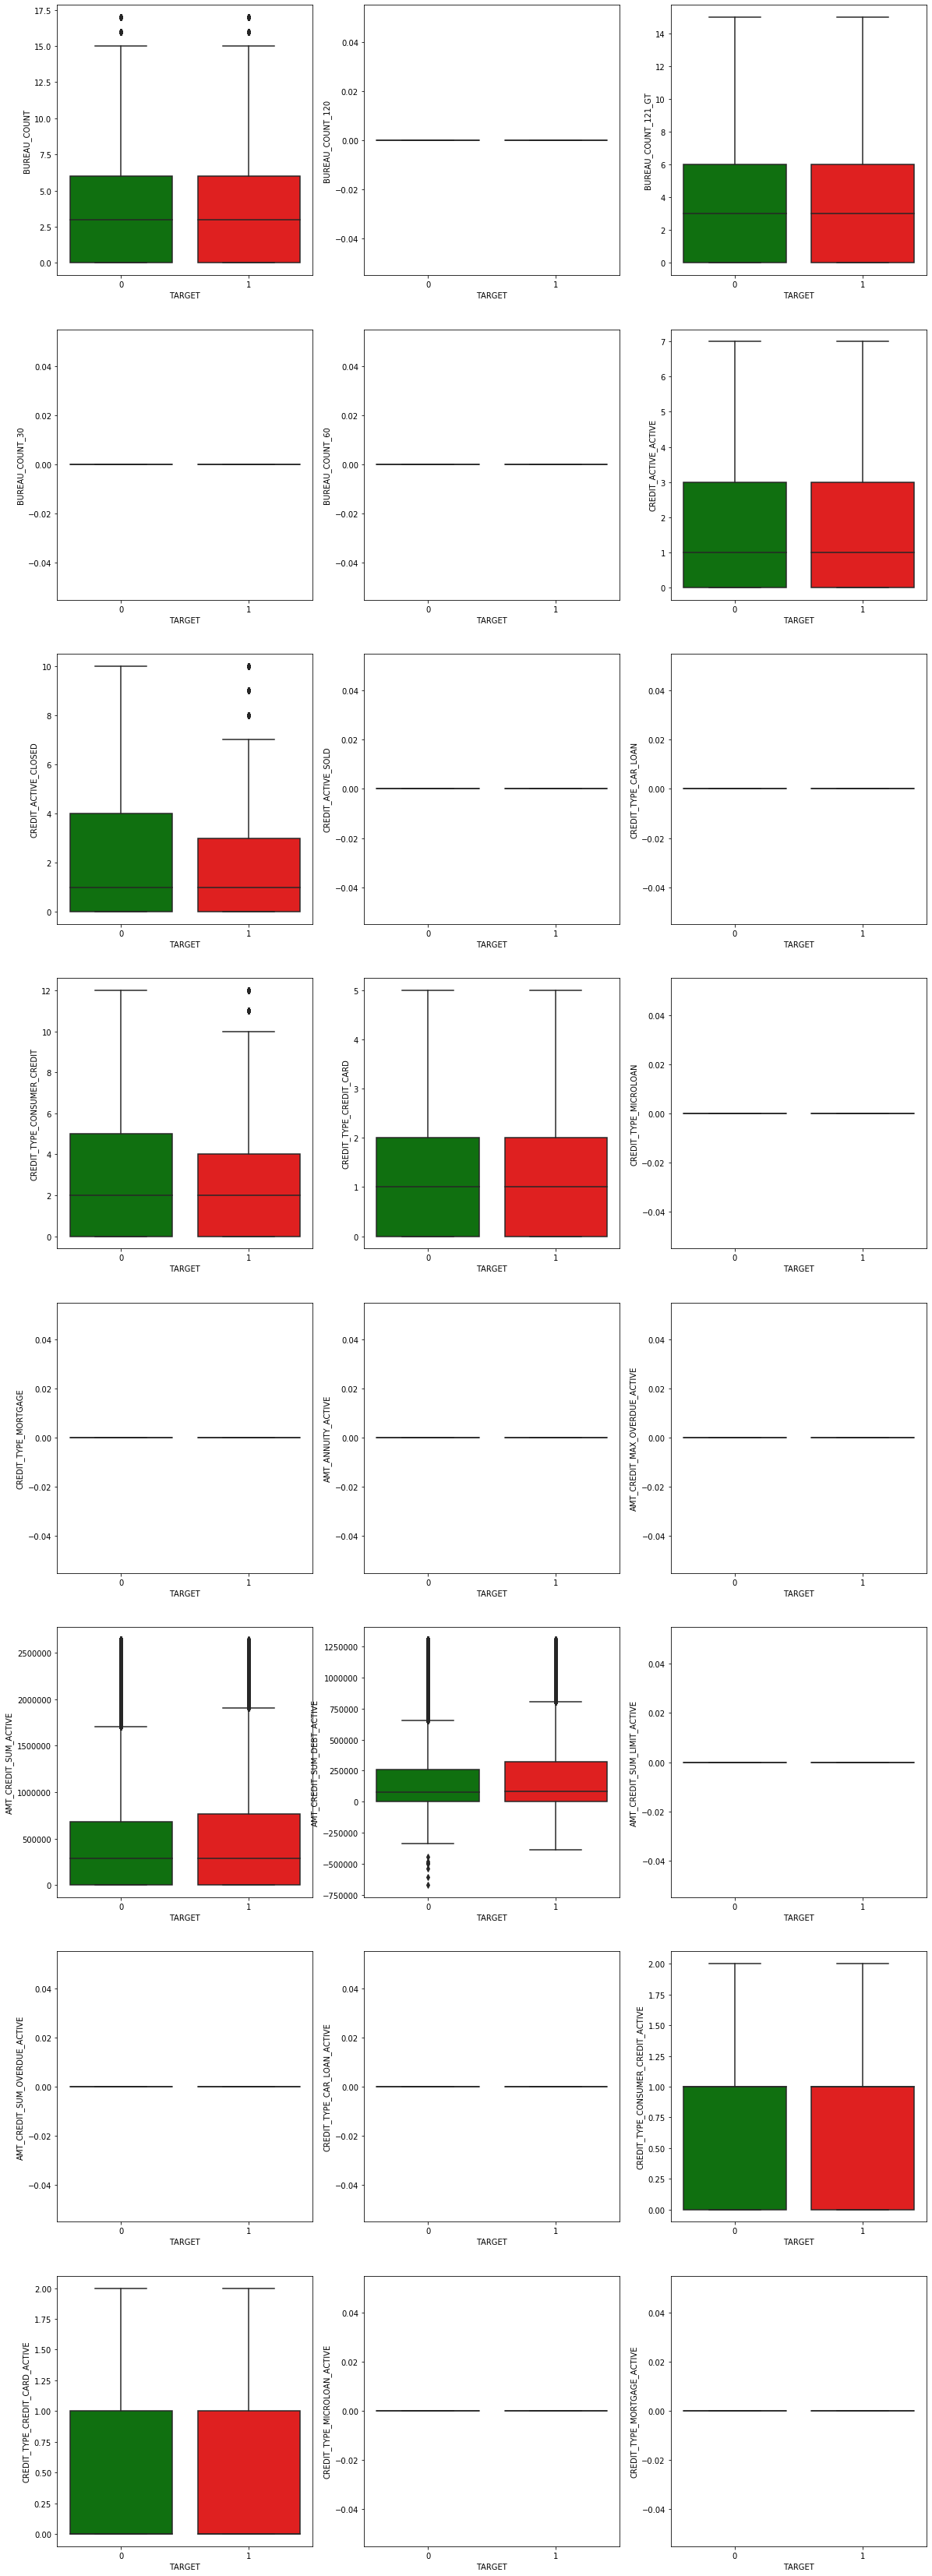

In [52]:
df_merged_app_removed_outliers = df_merged_app.copy()
#Replace outliers with median value instead
replace_outlier(df_merged_app_removed_outliers, bureau_cols)

#Plot box plots between bureau columns vs. TARGET
fig, axis = plt.subplots(8,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(bureau_cols):
    sns.boxplot(y=f, x='TARGET', data=df_merged_app_removed_outliers, ax = axis[i], palette=pal)

**Insight:**<br>
Below features have unique value after removing the outliers. These do not seem to be a good predictor for TARGET value. These will be removed from the dataset<br>
- BUREAU_COUNT_120
- BUREAU_COUNT_30
- BUREAU_COUNT_60
- CREDIT_ACTIVE_SOLD
- CREDIT_TYPE_CAR_LOAN
- CREDIT_TYPE_MICROLOAN
- CREDIT_TYPE_MORTGAGE
- AMT_ANNUITY_ACTIVE
- AMT_CREDIT_MAX_OVERDUE_ACTIVE
- AMT_CREDIT_SUM_LIMIT_ACTIVE
- AMT_CREDIT_SUM_OVERDUE_ACTIVE
- CREDIT_TYPE_CAR_LOAN_ACTIVE
- CREDIT_TYPE_MICROLOAN_ACTIVE
- CREDIT_TYPE_MORTGAGE_ACTIVE<br>

The remaining features, we will explore futher the relation between them and TARGET by visualization tool PowerPI.

In [53]:
cols2drop = ['BUREAU_COUNT_120', 'BUREAU_COUNT_30', 'BUREAU_COUNT_60',
            'CREDIT_ACTIVE_SOLD', 'CREDIT_TYPE_CAR_LOAN', 'CREDIT_TYPE_MICROLOAN',
            'CREDIT_TYPE_MORTGAGE', 'AMT_ANNUITY_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE_ACTIVE',
            'AMT_CREDIT_SUM_LIMIT_ACTIVE', 'AMT_CREDIT_SUM_OVERDUE_ACTIVE', 'CREDIT_TYPE_CAR_LOAN_ACTIVE',
            'CREDIT_TYPE_MICROLOAN_ACTIVE', 'CREDIT_TYPE_MORTGAGE_ACTIVE']
df_merged_app = df_merged_app.drop(columns = cols2drop, axis = 1)
df_merged_app.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,BUREAU_COUNT,BUREAU_COUNT_121_GT,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,8.0,7.0,2.0,6.0,4.0,4.0,481988.565,245781.0,1.0,1.0
1,100003,0,270000.0,1293502.5,35698.5,-1188,-1186.0,-291,0.311267,0.622246,...,4.0,4.0,1.0,3.0,2.0,2.0,810000.000,0.0,0.0,1.0
2,100004,0,67500.0,135000.0,6750.0,-225,-4260.0,-2531,0.505998,0.555912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,-3039,-9833.0,-2437,0.505998,0.650442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,100007,0,121500.0,513000.0,21865.5,-3038,-4311.0,-3458,0.505998,0.322738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


## 2.3. Previous Application

### Any features in Previous Application data correlates with TARGET?

We try to answer above question using box plots to see if the distribution of the features change between 2 TARGET values.

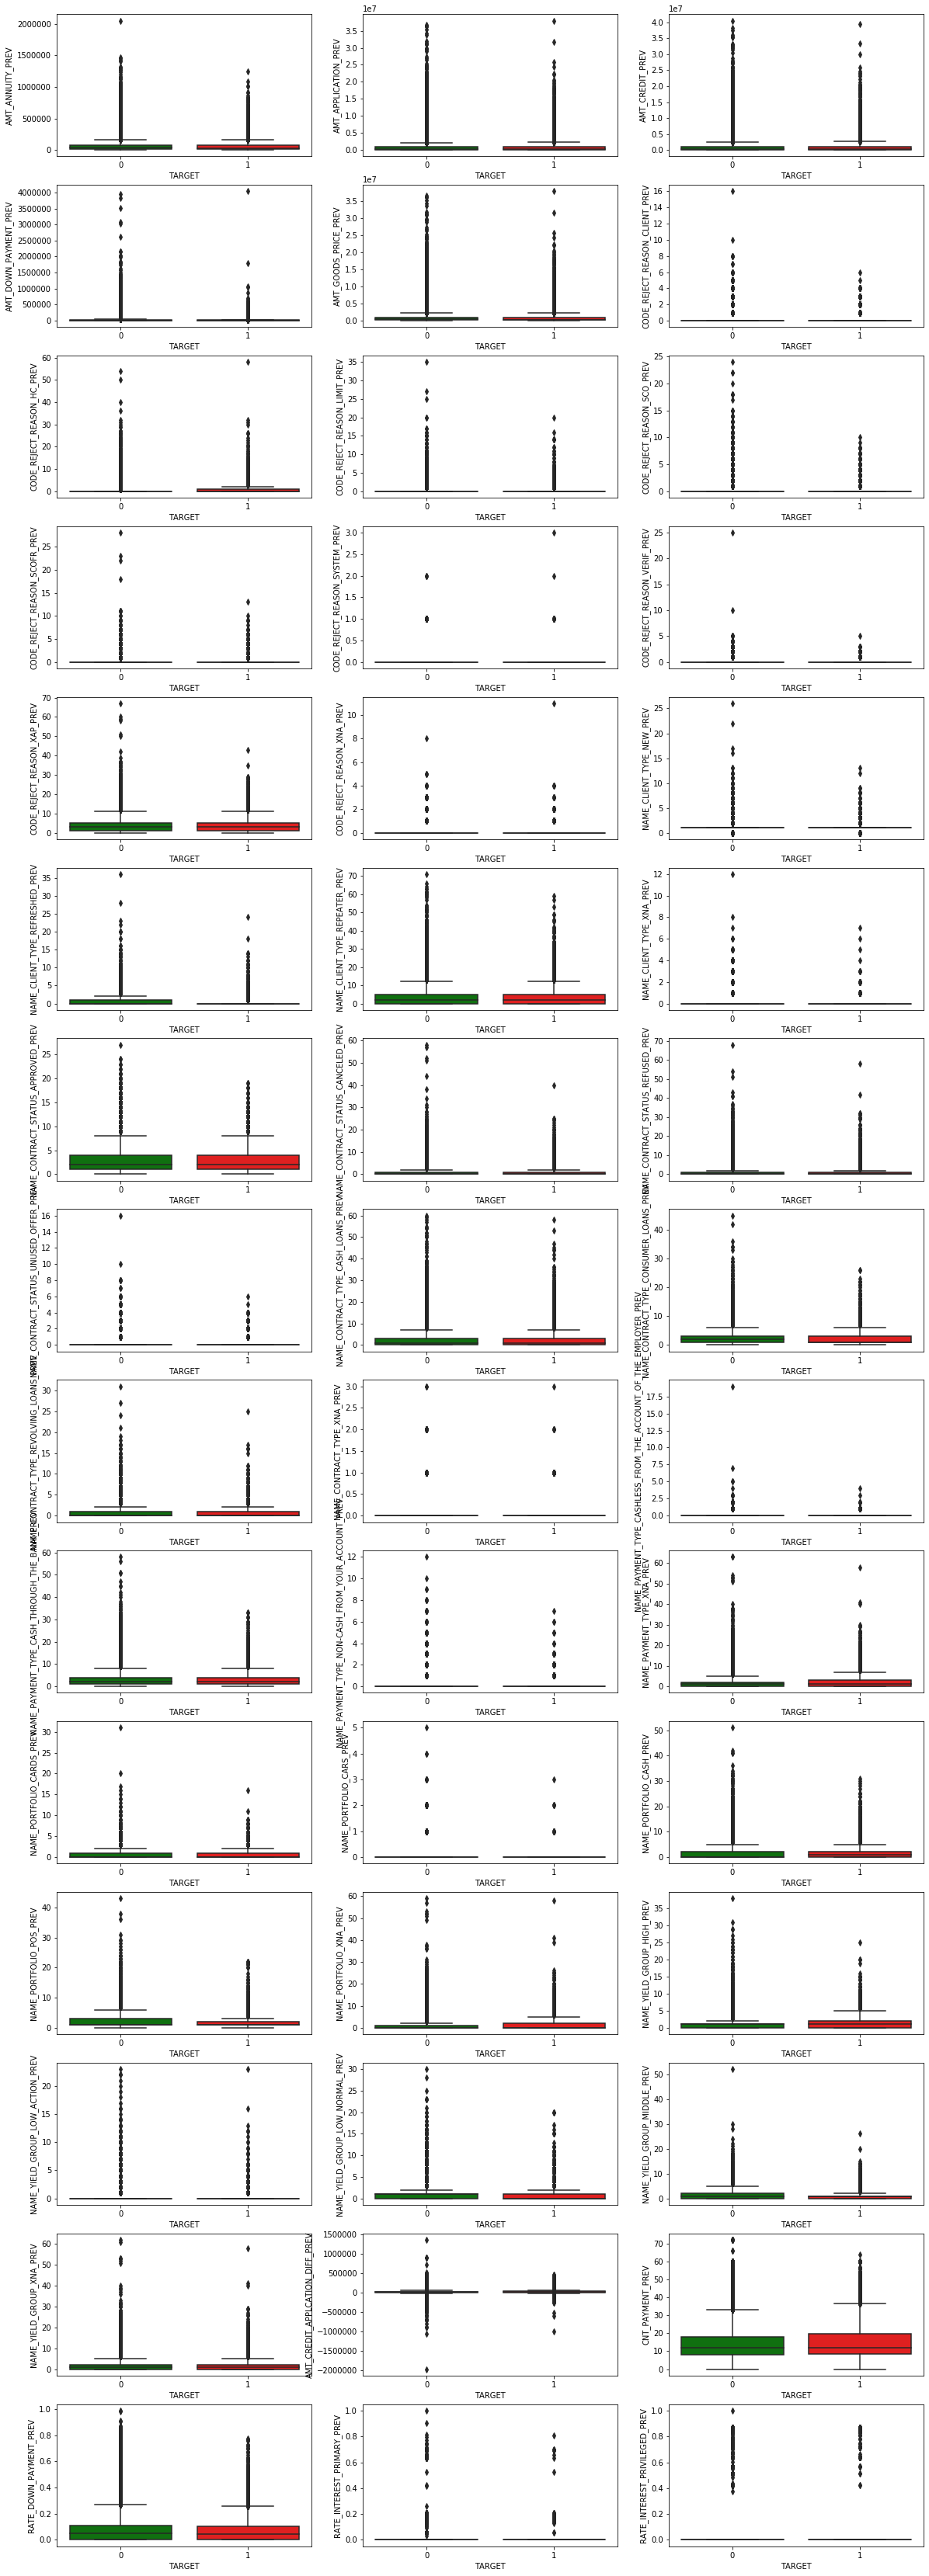

In [54]:
prev_application_cols = list(df_final_prev_application.columns)

#Plot box plots between Prev_application columns vs. TARGET
fig, axis = plt.subplots(15,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(prev_application_cols):
    sns.boxplot(y=f, x='TARGET', data=df_merged_app, ax = axis[i], palette=pal)

**Insight:** There are a lot of outliers which affect the distribution. The outliers will be replaced by medians, so we can have better view of data distributions.</font>

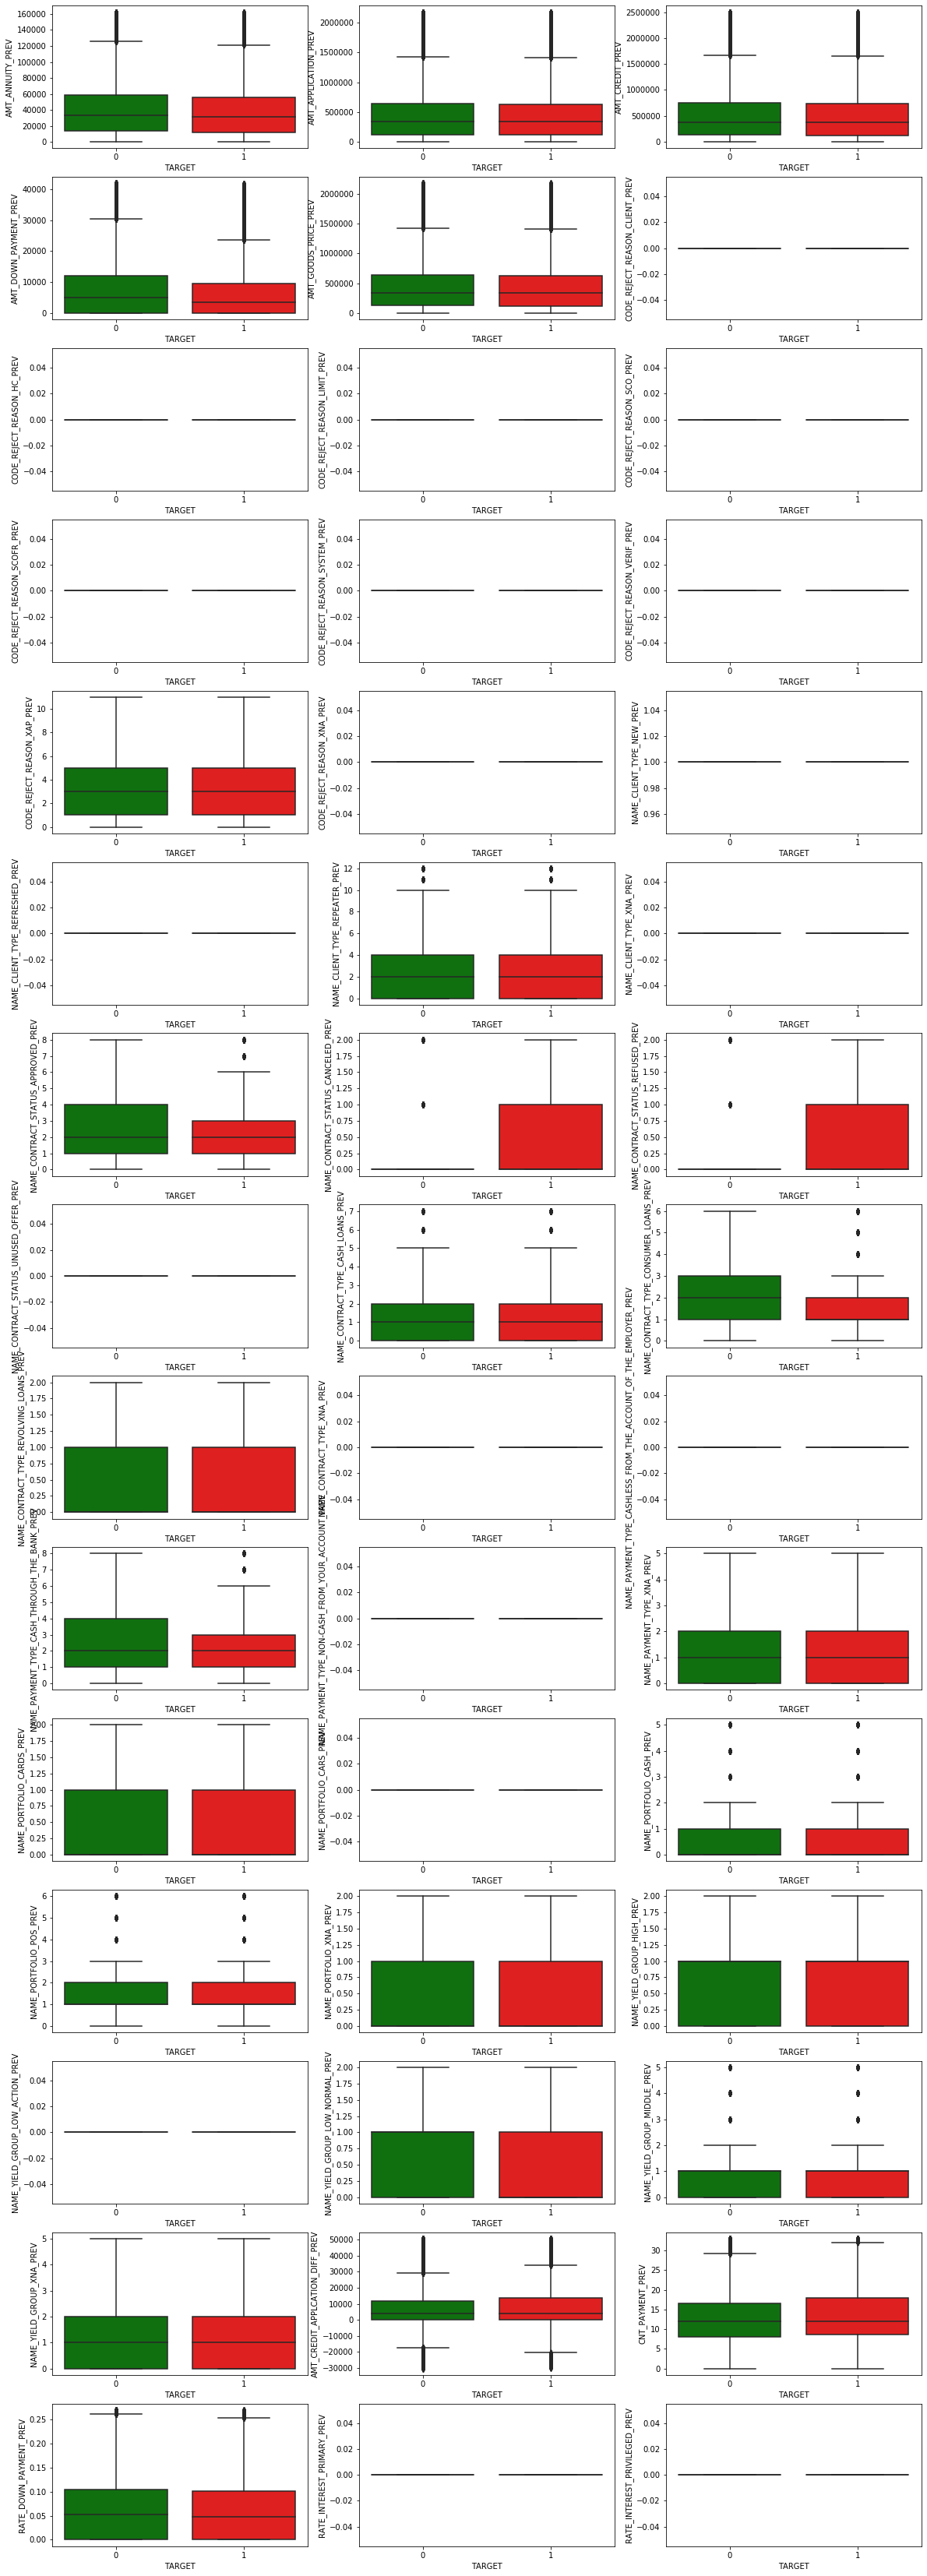

In [55]:
#Replace outliers with median value instead
replace_outlier(df_merged_app_removed_outliers , prev_application_cols)

#Plot box plots between bureau columns vs. TARGET
fig, axis = plt.subplots(15,3,figsize = (20,60))
axis = axis.flatten()

pal = ['green', 'red']

for i, f in enumerate(prev_application_cols):
    sns.boxplot(y=f, x='TARGET', data=df_merged_app_removed_outliers, ax = axis[i], palette=pal)

**Insight:**<br>
Below features have unique value after removing the outliers. These do not seem to be a good predictor for TARGET value. These will be removed from the dataset<br>
- CODE_REJECT_REASON_CLIENT_PREV
- CODE_REJECT_REASON_HC_PREV
- CODE_REJECT_REASON_LIMIT_PREV
- CODE_REJECT_REASON_SCO_PREV
- CODE_REJECT_REASON_SCOFR_PREV
- CODE_REJECT_REASON_SYSTEM_PREV
- CODE_REJECT_REASON_VERIF_PREV
- CODE_REJECT_REASON_XNA_PREV
- NAME_CLIENT_TYPE_NEW_PREV
- NAME_CLIENT_TYPE_REFRESHED_PREV
- NAME_CLIENT_TYPE_XNA_PREV
- NAME_CONTRACT_STATUS_UNUSED_OFFER_PREV
- NAME_CONTRACT_TYPE_XNA_PREV
- NAME_CONTRACT_TYPE_XNA_PREV
- etc. <br></font>

In [56]:
#Drop columns that have unanimous value
cols2drop = []

for i, f in enumerate(prev_application_cols):
    if len(df_merged_app_removed_outliers[f].unique())==1:
        cols2drop = cols2drop + [f]

df_merged_app = df_merged_app.drop(columns = cols2drop, axis = 1)
df_merged_app.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,BUREAU_COUNT,BUREAU_COUNT_121_GT,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,8.0,7.0,2.0,6.0,4.0,4.0,481988.565,245781.0,1.0,1.0
1,100003,0,270000.0,1293502.5,35698.5,-1188,-1186.0,-291,0.311267,0.622246,...,4.0,4.0,1.0,3.0,2.0,2.0,810000.000,0.0,0.0,1.0
2,100004,0,67500.0,135000.0,6750.0,-225,-4260.0,-2531,0.505998,0.555912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,-3039,-9833.0,-2437,0.505998,0.650442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,100007,0,121500.0,513000.0,21865.5,-3038,-4311.0,-3458,0.505998,0.322738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


Let's look at "NAME_CONTRACT_STATUS!"

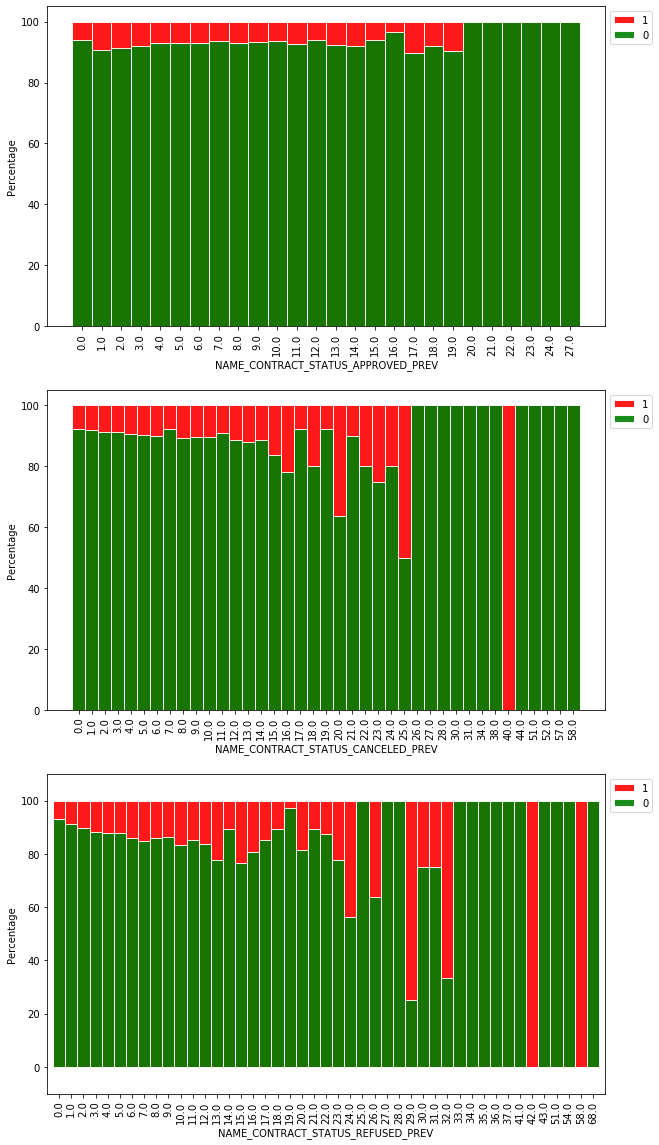

In [57]:
#Filter out 'FLAG_DOCUMENT' variables
contract_status_cols = [col for col in df_merged_app if col.startswith('NAME_CONTRACT_STATUS')]

fig, axis = plt.subplots(3,1,figsize = (10,20))
axis = axis.flatten()

pal = ['red', 'green']

for i, f in enumerate(contract_status_cols):
    df_percentage = category_percentage_by_target(df_merged_app, 'TARGET', f)
    df_percentage = df_percentage.transpose().sort_index().transpose()
    plot_stacked_percentage_bar(df_percentage, f, ax=axis[i], palette=pal)

**Insight:** While the %default does not seems to change per # of approved application, the higher the # of cancelled or refused application, the higher chance of default in general.</font>

## 3. Basic Prediction Model

### 3.1. Outliers and NaN values

In [58]:
# Check if any columns have missing values
numeric_nan_fill = df_merged_app.columns[df_merged_app.isnull().any()].tolist()

# Exclude the EXT_SOURCE for median nan replacement these will be replaced with a different method
# numeric_nan_fill.remove('EXT_SOURCE_1')
# numeric_nan_fill.remove('EXT_SOURCE_2')
# numeric_nan_fill.remove('EXT_SOURCE_3')

numeric_nan_fill

[]

In [59]:
df_transformed_data = df_merged_app.copy()
# Replace nan with median values per feature
for f in numeric_nan_fill:
    df_transformed_data[f].fillna((df_transformed_data[f].median()), inplace=True)

# Display top n records
display(df_transformed_data.head(n=1))

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,...,BUREAU_COUNT,BUREAU_COUNT_121_GT,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE
0,100002,1,202500.0,406597.5,24700.5,-637,-3648.0,-2120,0.083037,0.262949,...,8.0,7.0,2.0,6.0,4.0,4.0,481988.565,245781.0,1.0,1.0


In [60]:
df_transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 64 columns):
SK_ID_CURR                                      307511 non-null int64
TARGET                                          307511 non-null int64
AMT_INCOME_TOTAL                                307511 non-null float64
AMT_CREDIT                                      307511 non-null float64
AMT_ANNUITY                                     307511 non-null float64
DAYS_EMPLOYED                                   307511 non-null int64
DAYS_REGISTRATION                               307511 non-null float64
DAYS_ID_PUBLISH                                 307511 non-null int64
EXT_SOURCE_1                                    307511 non-null float64
EXT_SOURCE_2                                    307511 non-null float64
EXT_SOURCE_3                                    307511 non-null float64
DAYS_LAST_PHONE_CHANGE                          307511 non-null float64
FLAG_DOCUMENT_2                  

In [61]:
#Take absolute of day-values
days_cols = [col for col in df_application_train if col.startswith('DAYS')]

# Transform negative to absolute for days columns since time is relative to application
# if the value is negative, turn it to positive, else, make it 0
df_transformed_data[days_cols] = df_transformed_data[days_cols].mask(df_transformed_data[days_cols]>0,0)
df_transformed_data[days_cols] = df_transformed_data[days_cols].apply(lambda x: abs(x))
df_transformed_data[days_cols].head()

,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,637,3648.0,2120,1134.0
1,1188,1186.0,291,828.0
2,225,4260.0,2531,815.0
3,3039,9833.0,2437,617.0
4,3038,4311.0,3458,1106.0


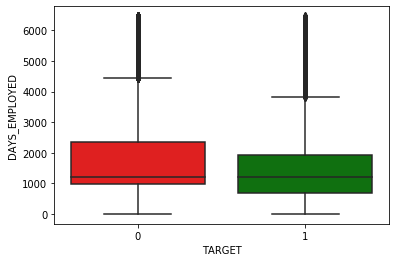

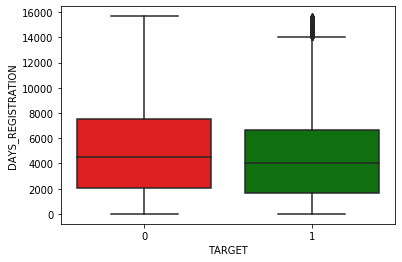

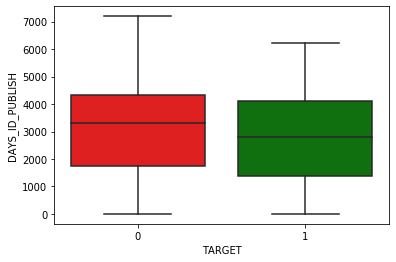

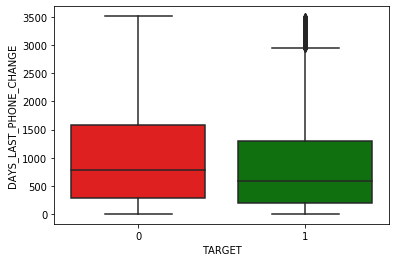

In [62]:
for i, f in enumerate(days_cols):
    sns.boxplot(y=f, x='TARGET', data=df_transformed_data, palette=pal)
    plt.show()

### 3.2. Basic prediction model using Random Forest Classifier

In [63]:
x=[i for i in df_transformed_data.columns if i not in ['TARGET', 'SK_ID_CURR']]
X = df_transformed_data[x]
y = df_transformed_data['TARGET']
X.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,...,BUREAU_COUNT,BUREAU_COUNT_121_GT,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE
0,202500.0,406597.5,24700.5,637,3648.0,2120,0.083037,0.262949,0.139376,1134.0,...,8.0,7.0,2.0,6.0,4.0,4.0,481988.565,245781.0,1.0,1.0
1,270000.0,1293502.5,35698.5,1188,1186.0,291,0.311267,0.622246,0.535276,828.0,...,4.0,4.0,1.0,3.0,2.0,2.0,810000.000,0.0,0.0,1.0
2,67500.0,135000.0,6750.0,225,4260.0,2531,0.505998,0.555912,0.729567,815.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,3039,9833.0,2437,0.505998,0.650442,0.535276,617.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,121500.0,513000.0,21865.5,3038,4311.0,3458,0.505998,0.322738,0.535276,1106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [64]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators=100,
                                class_weight='balanced', 
                                random_state=0)
clf.fit(X, y)
print(clf.feature_importances_)

[8.18489258e-03 1.90782471e-02 1.68927278e-02 5.01126455e-02
 1.88231480e-02 2.42312680e-02 8.01711847e-02 2.10287584e-01
 2.04686816e-01 3.13648088e-02 1.65503709e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.01533555e-05 2.07696190e-05
 3.72558700e-06 3.19913047e-05 4.04986893e-03 9.29953389e-06
 2.68679340e-02 2.23437882e-03 4.13240882e-03 1.04895757e-03
 1.25661096e-03 6.69764826e-04 1.27060195e-02 1.09670712e-02
 1.13518955e-02 2.42945984e-02 1.09207898e-02 5.47859125e-03
 4.66062227e-03 8.05818281e-03 2.33401452e-03 2.14276402e-02
 3.79602552e-03 4.49344530e-03 5.66491203e-03 4.45162317e-03
 5.63814008e-03 4.23916291e-03 3.00486597e-03 4.40017821e-03
 3.18344275e-03 9.64049791e-03 6.10511313e-03 2.56307402e-03
 6.10862810e-03 1.85442415e-02 1.62042101e-02 1.00005111e-02
 5.89193858e-03 6.38232614e-03 1.08074810e-02 7.59182716e-03
 5.53575764e-03 3.68494995e-03 1.12484154e-02 1.31950876e-02
 4.47681212e-03 6.71217030e-03]


**Model evaluation**
- Accuracy: 0.75
- Recall Score: 0.19
- Precision score: 0.70

In [65]:
y_pred = clf.predict(X)
print('Accuracy of RandomForestClassifier on test set: {:.2f}'.format(clf.score(X, y)))

Accuracy of RandomForestClassifier on test set: 0.75


In [66]:
from sklearn.metrics import recall_score
recall_score(y_pred, y)

0.19866061242185004

In [67]:
from sklearn.metrics import precision_score
precision_score(y_pred, y)

0.7014300100704934

In [68]:
corr_matrix = df_transformed_data[x+['TARGET']].corr()
corr_matrix

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,...,BUREAU_COUNT_121_GT,CREDIT_ACTIVE_ACTIVE,CREDIT_ACTIVE_CLOSED,CREDIT_TYPE_CONSUMER_CREDIT,CREDIT_TYPE_CREDIT_CARD,AMT_CREDIT_SUM_ACTIVE,AMT_CREDIT_SUM_DEBT_ACTIVE,CREDIT_TYPE_CONSUMER_CREDIT_ACTIVE,CREDIT_TYPE_CREDIT_CARD_ACTIVE,TARGET
AMT_INCOME_TOTAL,1.000000,0.327210,0.396656,0.077602,-0.065998,-0.028147,0.036375,0.143635,-0.074140,0.059343,...,0.143779,0.148993,0.111205,0.101003,0.148985,0.194228,0.156097,0.077277,0.136243,-0.014807
AMT_CREDIT,0.327210,1.000000,0.724273,0.086314,-0.003039,0.004850,0.099958,0.113061,0.029174,0.078213,...,0.068817,0.053317,0.056513,0.043580,0.072242,0.103378,0.076157,0.013347,0.063511,-0.022309
AMT_ANNUITY,0.396656,0.724273,1.000000,0.076083,-0.037935,-0.016232,0.064075,0.109505,0.011044,0.067649,...,0.040501,0.018186,0.035299,0.012553,0.051866,0.110462,0.084210,-0.024641,0.041476,0.000244
DAYS_EMPLOYED,0.077602,0.086314,0.076083,1.000000,0.019833,0.043175,0.079950,0.081999,0.061733,0.132992,...,0.115103,0.073402,0.110273,0.109032,0.061212,0.081904,0.059210,0.065028,0.044884,-0.050047
DAYS_REGISTRATION,-0.065998,-0.003039,-0.037935,0.019833,1.000000,0.099812,0.110235,0.059291,0.095087,0.056441,...,-0.014750,-0.026801,-0.008841,-0.002280,-0.021159,-0.091208,-0.084530,-0.003011,-0.016620,-0.041399
DAYS_ID_PUBLISH,-0.028147,0.004850,-0.016232,0.043175,0.099812,1.000000,0.089020,0.050881,0.111864,0.088170,...,0.100435,0.043115,0.107948,0.102599,0.044452,0.008964,0.001386,0.036808,0.031397,-0.051457
EXT_SOURCE_1,0.036375,0.099958,0.064075,0.079950,0.110235,0.089020,1.000000,0.134993,0.109100,0.086152,...,0.066017,0.029482,0.064763,0.058439,0.040074,0.030411,0.013952,0.021676,0.027667,-0.098887
EXT_SOURCE_2,0.143635,0.113061,0.109505,0.081999,0.059291,0.050881,0.134993,1.000000,0.094147,0.193858,...,0.037439,0.013543,0.032711,0.016770,0.040411,0.068618,0.053130,-0.018132,0.032112,-0.160295
EXT_SOURCE_3,-0.074140,0.029174,0.011044,0.061733,0.095087,0.111864,0.109100,0.094147,1.000000,0.062940,...,-0.219136,-0.374026,-0.135575,-0.186112,-0.287436,-0.111270,-0.119195,-0.273524,-0.320614,-0.155892
DAYS_LAST_PHONE_CHANGE,0.059343,0.078213,0.067649,0.132992,0.056441,0.088170,0.086152,0.193858,0.062940,1.000000,...,0.137661,0.091048,0.129674,0.124345,0.093751,0.065081,0.051533,0.064313,0.077600,-0.054964


In [70]:
#corr_matrix.to_csv('corr_matrix.csv')